# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

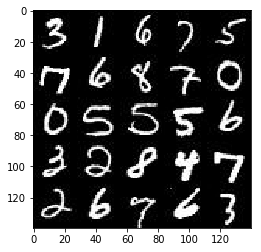

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

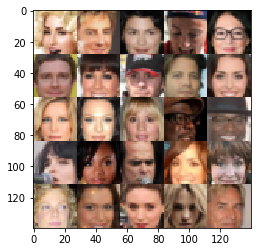

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [53]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # 1st convolutional layer.
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=(2,2), padding='same')
        # Batch normalization. DON'T USE HERE, CREATES ARTEFACTS
         # Leaky ReLU.
        relu1 = tf.maximum(alpha * x1, x1)
        
        # 2nd convolutional layer.
        x2 = tf.layers.conv2d(relu1, filters=128, kernel_size=5, strides=(2,2), padding='same')
        # Batch normalization.
        b2 = tf.layers.batch_normalization(x2, training=True)
         # Leaky ReLU.
        relu2 = tf.maximum(alpha * b2, b2)
        
        # 3rd convolutional layer.
        x3 = tf.layers.conv2d(relu2, filters=256, kernel_size=5, strides=(2,2), padding='same')
        # Batch normalization.
        b3 = tf.layers.batch_normalization(x3, training=True)
         # Leaky ReLU.
        relu3 = tf.maximum(alpha * b3, b3)
        
        # Turn last layer into vector.
        x4 = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(x4, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [54]:
def generator(z, out_channel_dim, training=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not training):
        # First fully connected layer
        # TF does not have leaky ReLU built in, so we use no
        # activation fuction but create it afterwards
        h1 = tf.layers.dense(z, 4*4*512, activation=None)
        # Reshape into 3d array to start the convolutional part of the network.
        h1 = tf.reshape(h1, (-1, 4, 4, 512))
        # Batch normalization.
        h1 = tf.layers.batch_normalization(h1, training=training)
        # Leaky ReLU activation function.
        h1 = tf.maximum(alpha * h1, h1)
        # h1 now has a dimension of 4x4x512
        
        # 2nd convolutional layer 7x7x256
        h2 = tf.layers.conv2d_transpose(h1, filters=256, kernel_size=4, strides=(1,1), padding='valid')
        # Batch normalization.
        h2 = tf.layers.batch_normalization(h2, training=training)
         # Leaky ReLU.
        h2 = tf.maximum(alpha * h2, h2)
         
        # 3rd convolutional layer 14x14x128
        h3 = tf.layers.conv2d_transpose(h2, filters=128, kernel_size=5, strides=(2,2), padding='same')
        # Batch normalization.
        h3 = tf.layers.batch_normalization(h3, training=training)
         # Leaky ReLU.
        h3 = tf.maximum(alpha * h3, h3)
        
        # Output layer, 28x28x3
        logits = tf.layers.conv2d_transpose(inputs=h3, filters=out_channel_dim, kernel_size=5, strides=(2,2), padding='same')
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [55]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [56]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [189]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np
import matplotlib
def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode, losses):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    
    matplotlib.rcParams['figure.figsize'] = [10,6]
    pyplot.subplot(1, 2, 1)
    pyplot.plot(range(len(losses)), [i[1] for i in losses], '-g', label='Gen loss')
    pyplot.plot(range(len(losses)), [i[0] for i in losses], '-r', label='Dis loss')
    pyplot.xlabel("Step")
    pyplot.ylabel("Loss")
    pyplot.legend()
    pyplot.grid()
    pyplot.gca().set_xlim((0,len(losses)))
    pyplot.gca().set_ylim((0,10))
    pyplot.gca().set_aspect(len(losses)/10.)
    pyplot.subplot(1, 2, 2)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [190]:
import time
from matplotlib import pyplot as plt
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build model.
    # Create inputs.
    input_real, input_z, learning_rate_placeholder = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    # Create losses.
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    # Create optimizers.
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_placeholder, beta1)

    print_every = 10
    show_every = 100
        
    losses = []
    steps = 0
        
    time_start = time.time()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Rescale batch images to range from -1 to 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_placeholder:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learning_rate_placeholder:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    time_elapsed = time.time() - time_start
                    progress = steps / (epoch_count * (data_shape[0]/batch_size))
                    time_to_finish = time_elapsed / progress - time_elapsed
                    print("Epc: {}/{}    ".format(epoch_i+1, epochs) +
                          "Bat: {:04g}/{}    ".format(steps - epoch_i*int(data_shape[0]/batch_size), int(data_shape[0]/batch_size)) +
                          "Dis Loss: {:.4f}    ".format(train_loss_d) +
                          "Gen Loss: {:.4f}    ".format(train_loss_g) +
                          "Time elaps: {}    ".format(time.strftime("%H:%M:%S", time.gmtime(time_elapsed))) +
                          "Time remain: {}.".format(time.strftime("%H:%M:%S", time.gmtime(time_to_finish))))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode, losses)
                    '''
                    plt.plot(range(len(losses)), [i[0] for i in losses], '-r', label='Dis loss')
                    plt.plot(range(len(losses)), [i[1] for i in losses], '-g', label='Gen loss')
                    plt.xlabel("Step")
                    plt.ylabel("Loss")
                    plt.legend()
                    plt.show()
                    '''

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epc: 1/2    Bat: 0010/1200    Dis Loss: 1.3803    Gen Loss: 15.6087    Time elaps: 00:00:01    Time remain: 00:07:41.
Epc: 1/2    Bat: 0020/1200    Dis Loss: 0.0921    Gen Loss: 16.8544    Time elaps: 00:00:03    Time remain: 00:06:45.
Epc: 1/2    Bat: 0030/1200    Dis Loss: 0.1494    Gen Loss: 3.6232    Time elaps: 00:00:04    Time remain: 00:06:26.
Epc: 1/2    Bat: 0040/1200    Dis Loss: 1.2054    Gen Loss: 0.8663    Time elaps: 00:00:06    Time remain: 00:06:16.
Epc: 1/2    Bat: 0050/1200    Dis Loss: 0.3780    Gen Loss: 3.3904    Time elaps: 00:00:07    Time remain: 00:06:10.
Epc: 1/2    Bat: 0060/1200    Dis Loss: 0.9392    Gen Loss: 5.5800    Time elaps: 00:00:09    Time remain: 00:06:05.
Epc: 1/2    Bat: 0070/1200    Dis Loss: 0.8240    Gen Loss: 1.2972    Time elaps: 00:00:10    Time remain: 00:06:01.
Epc: 1/2    Bat: 0080/1200    Dis Loss: 0.7434    Gen Loss: 1.1407    Time elaps: 00:00:12    Time remain: 00:05:57.
Epc: 1/2    Bat: 0090/1200    Dis Loss: 0.4804    Gen Loss: 3.

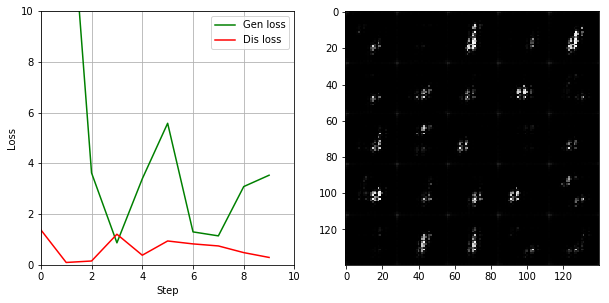

Epc: 1/2    Bat: 0110/1200    Dis Loss: 3.2211    Gen Loss: 0.0988    Time elaps: 00:00:17    Time remain: 00:05:56.
Epc: 1/2    Bat: 0120/1200    Dis Loss: 1.7288    Gen Loss: 0.4792    Time elaps: 00:00:18    Time remain: 00:05:53.
Epc: 1/2    Bat: 0130/1200    Dis Loss: 0.8124    Gen Loss: 1.0478    Time elaps: 00:00:20    Time remain: 00:05:51.
Epc: 1/2    Bat: 0140/1200    Dis Loss: 0.7756    Gen Loss: 1.0994    Time elaps: 00:00:21    Time remain: 00:05:48.
Epc: 1/2    Bat: 0150/1200    Dis Loss: 1.7023    Gen Loss: 3.2023    Time elaps: 00:00:23    Time remain: 00:05:46.
Epc: 1/2    Bat: 0160/1200    Dis Loss: 1.1001    Gen Loss: 0.9400    Time elaps: 00:00:24    Time remain: 00:05:43.
Epc: 1/2    Bat: 0170/1200    Dis Loss: 0.6843    Gen Loss: 2.4020    Time elaps: 00:00:26    Time remain: 00:05:41.
Epc: 1/2    Bat: 0180/1200    Dis Loss: 0.7727    Gen Loss: 1.5815    Time elaps: 00:00:27    Time remain: 00:05:39.
Epc: 1/2    Bat: 0190/1200    Dis Loss: 0.7709    Gen Loss: 1.45

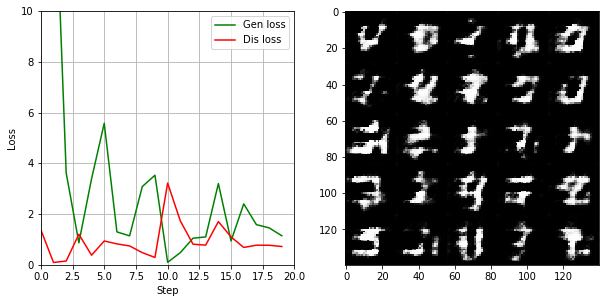

Epc: 1/2    Bat: 0210/1200    Dis Loss: 1.3769    Gen Loss: 0.5371    Time elaps: 00:00:32    Time remain: 00:05:37.
Epc: 1/2    Bat: 0220/1200    Dis Loss: 0.9298    Gen Loss: 1.1109    Time elaps: 00:00:33    Time remain: 00:05:35.
Epc: 1/2    Bat: 0230/1200    Dis Loss: 1.1909    Gen Loss: 0.5806    Time elaps: 00:00:35    Time remain: 00:05:33.
Epc: 1/2    Bat: 0240/1200    Dis Loss: 1.2984    Gen Loss: 0.6414    Time elaps: 00:00:36    Time remain: 00:05:31.
Epc: 1/2    Bat: 0250/1200    Dis Loss: 0.6997    Gen Loss: 1.7400    Time elaps: 00:00:38    Time remain: 00:05:29.
Epc: 1/2    Bat: 0260/1200    Dis Loss: 0.7748    Gen Loss: 1.5103    Time elaps: 00:00:39    Time remain: 00:05:27.
Epc: 1/2    Bat: 0270/1200    Dis Loss: 1.0903    Gen Loss: 1.1198    Time elaps: 00:00:41    Time remain: 00:05:25.
Epc: 1/2    Bat: 0280/1200    Dis Loss: 0.7907    Gen Loss: 1.7673    Time elaps: 00:00:42    Time remain: 00:05:23.
Epc: 1/2    Bat: 0290/1200    Dis Loss: 1.2899    Gen Loss: 0.58

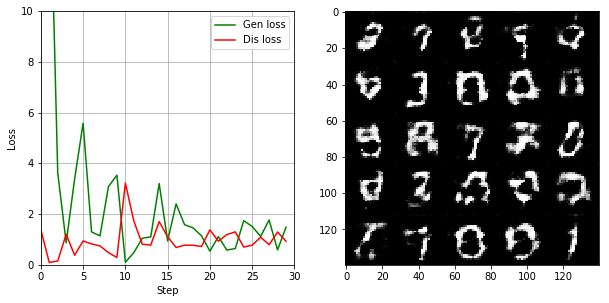

Epc: 1/2    Bat: 0310/1200    Dis Loss: 1.1012    Gen Loss: 0.9444    Time elaps: 00:00:47    Time remain: 00:05:20.
Epc: 1/2    Bat: 0320/1200    Dis Loss: 1.5997    Gen Loss: 2.4166    Time elaps: 00:00:48    Time remain: 00:05:18.
Epc: 1/2    Bat: 0330/1200    Dis Loss: 1.0090    Gen Loss: 0.8308    Time elaps: 00:00:50    Time remain: 00:05:16.
Epc: 1/2    Bat: 0340/1200    Dis Loss: 1.6913    Gen Loss: 0.3545    Time elaps: 00:00:51    Time remain: 00:05:14.
Epc: 1/2    Bat: 0350/1200    Dis Loss: 1.1453    Gen Loss: 1.5473    Time elaps: 00:00:53    Time remain: 00:05:12.
Epc: 1/2    Bat: 0360/1200    Dis Loss: 0.7182    Gen Loss: 1.4445    Time elaps: 00:00:54    Time remain: 00:05:11.
Epc: 1/2    Bat: 0370/1200    Dis Loss: 1.1259    Gen Loss: 0.7035    Time elaps: 00:00:56    Time remain: 00:05:09.
Epc: 1/2    Bat: 0380/1200    Dis Loss: 0.8969    Gen Loss: 1.3961    Time elaps: 00:00:57    Time remain: 00:05:07.
Epc: 1/2    Bat: 0390/1200    Dis Loss: 0.9621    Gen Loss: 1.75

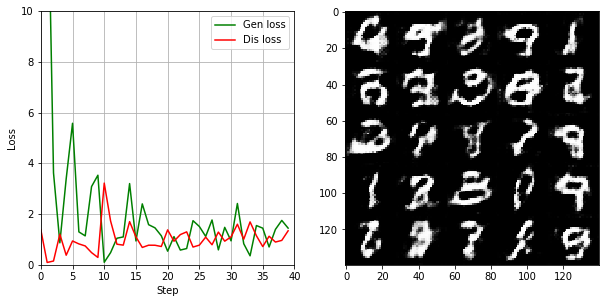

Epc: 1/2    Bat: 0410/1200    Dis Loss: 1.0069    Gen Loss: 0.8511    Time elaps: 00:01:02    Time remain: 00:05:04.
Epc: 1/2    Bat: 0420/1200    Dis Loss: 0.9579    Gen Loss: 0.8740    Time elaps: 00:01:04    Time remain: 00:05:02.
Epc: 1/2    Bat: 0430/1200    Dis Loss: 1.7757    Gen Loss: 0.3104    Time elaps: 00:01:05    Time remain: 00:05:00.
Epc: 1/2    Bat: 0440/1200    Dis Loss: 1.4670    Gen Loss: 0.4579    Time elaps: 00:01:07    Time remain: 00:04:59.
Epc: 1/2    Bat: 0450/1200    Dis Loss: 0.9011    Gen Loss: 1.5641    Time elaps: 00:01:08    Time remain: 00:04:57.
Epc: 1/2    Bat: 0460/1200    Dis Loss: 1.3546    Gen Loss: 1.7307    Time elaps: 00:01:10    Time remain: 00:04:55.
Epc: 1/2    Bat: 0470/1200    Dis Loss: 1.3059    Gen Loss: 2.0295    Time elaps: 00:01:11    Time remain: 00:04:53.
Epc: 1/2    Bat: 0480/1200    Dis Loss: 1.0204    Gen Loss: 0.9073    Time elaps: 00:01:13    Time remain: 00:04:52.
Epc: 1/2    Bat: 0490/1200    Dis Loss: 1.2180    Gen Loss: 0.52

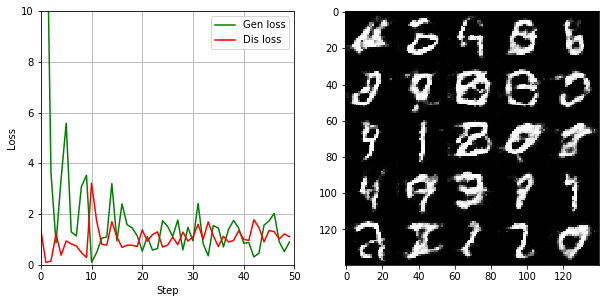

Epc: 1/2    Bat: 0510/1200    Dis Loss: 0.9068    Gen Loss: 1.3164    Time elaps: 00:01:17    Time remain: 00:04:48.
Epc: 1/2    Bat: 0520/1200    Dis Loss: 1.3871    Gen Loss: 0.4686    Time elaps: 00:01:19    Time remain: 00:04:46.
Epc: 1/2    Bat: 0530/1200    Dis Loss: 1.0580    Gen Loss: 0.6627    Time elaps: 00:01:20    Time remain: 00:04:45.
Epc: 1/2    Bat: 0540/1200    Dis Loss: 0.9612    Gen Loss: 1.0237    Time elaps: 00:01:22    Time remain: 00:04:43.
Epc: 1/2    Bat: 0550/1200    Dis Loss: 1.2233    Gen Loss: 1.8385    Time elaps: 00:01:23    Time remain: 00:04:41.
Epc: 1/2    Bat: 0560/1200    Dis Loss: 1.0076    Gen Loss: 0.9470    Time elaps: 00:01:25    Time remain: 00:04:40.
Epc: 1/2    Bat: 0570/1200    Dis Loss: 1.0595    Gen Loss: 0.8355    Time elaps: 00:01:26    Time remain: 00:04:38.
Epc: 1/2    Bat: 0580/1200    Dis Loss: 1.0752    Gen Loss: 1.0000    Time elaps: 00:01:28    Time remain: 00:04:36.
Epc: 1/2    Bat: 0590/1200    Dis Loss: 1.0151    Gen Loss: 1.18

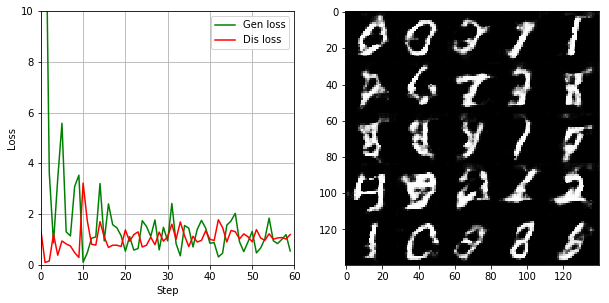

Epc: 1/2    Bat: 0610/1200    Dis Loss: 1.1841    Gen Loss: 0.7328    Time elaps: 00:01:33    Time remain: 00:04:33.
Epc: 1/2    Bat: 0620/1200    Dis Loss: 1.1045    Gen Loss: 0.6590    Time elaps: 00:01:34    Time remain: 00:04:31.
Epc: 1/2    Bat: 0630/1200    Dis Loss: 1.4282    Gen Loss: 0.4115    Time elaps: 00:01:36    Time remain: 00:04:29.
Epc: 1/2    Bat: 0640/1200    Dis Loss: 1.5644    Gen Loss: 1.7885    Time elaps: 00:01:37    Time remain: 00:04:28.
Epc: 1/2    Bat: 0650/1200    Dis Loss: 1.0385    Gen Loss: 1.2066    Time elaps: 00:01:39    Time remain: 00:04:26.
Epc: 1/2    Bat: 0660/1200    Dis Loss: 1.3861    Gen Loss: 0.4145    Time elaps: 00:01:40    Time remain: 00:04:24.
Epc: 1/2    Bat: 0670/1200    Dis Loss: 0.9561    Gen Loss: 1.0052    Time elaps: 00:01:41    Time remain: 00:04:23.
Epc: 1/2    Bat: 0680/1200    Dis Loss: 1.0579    Gen Loss: 0.6885    Time elaps: 00:01:43    Time remain: 00:04:21.
Epc: 1/2    Bat: 0690/1200    Dis Loss: 0.8568    Gen Loss: 1.26

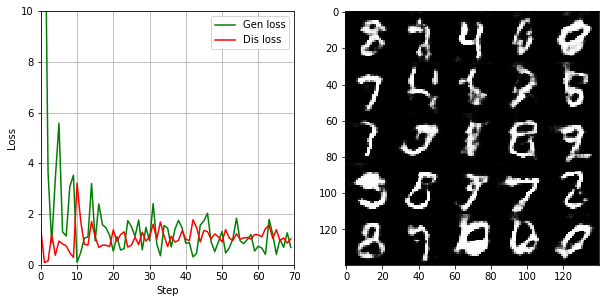

Epc: 1/2    Bat: 0710/1200    Dis Loss: 1.0448    Gen Loss: 0.7892    Time elaps: 00:01:48    Time remain: 00:04:17.
Epc: 1/2    Bat: 0720/1200    Dis Loss: 1.0871    Gen Loss: 1.1298    Time elaps: 00:01:49    Time remain: 00:04:16.
Epc: 1/2    Bat: 0730/1200    Dis Loss: 1.1108    Gen Loss: 0.7027    Time elaps: 00:01:51    Time remain: 00:04:14.
Epc: 1/2    Bat: 0740/1200    Dis Loss: 1.0750    Gen Loss: 0.5736    Time elaps: 00:01:52    Time remain: 00:04:12.
Epc: 1/2    Bat: 0750/1200    Dis Loss: 1.1300    Gen Loss: 1.4787    Time elaps: 00:01:54    Time remain: 00:04:11.
Epc: 1/2    Bat: 0760/1200    Dis Loss: 0.9171    Gen Loss: 1.2783    Time elaps: 00:01:55    Time remain: 00:04:09.
Epc: 1/2    Bat: 0770/1200    Dis Loss: 1.2474    Gen Loss: 1.5981    Time elaps: 00:01:57    Time remain: 00:04:08.
Epc: 1/2    Bat: 0780/1200    Dis Loss: 1.1812    Gen Loss: 0.5762    Time elaps: 00:01:58    Time remain: 00:04:06.
Epc: 1/2    Bat: 0790/1200    Dis Loss: 0.8654    Gen Loss: 1.31

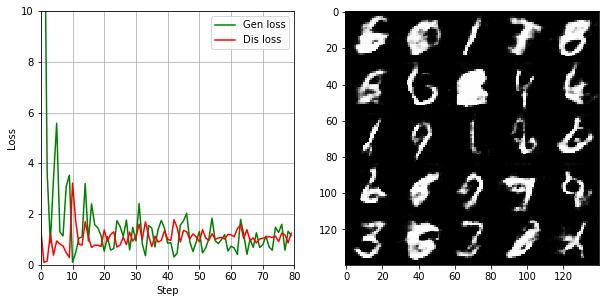

Epc: 1/2    Bat: 0810/1200    Dis Loss: 1.0123    Gen Loss: 1.1352    Time elaps: 00:02:03    Time remain: 00:04:02.
Epc: 1/2    Bat: 0820/1200    Dis Loss: 1.3812    Gen Loss: 0.4420    Time elaps: 00:02:04    Time remain: 00:04:00.
Epc: 1/2    Bat: 0830/1200    Dis Loss: 1.6102    Gen Loss: 0.2764    Time elaps: 00:02:06    Time remain: 00:03:59.
Epc: 1/2    Bat: 0840/1200    Dis Loss: 0.9812    Gen Loss: 0.7228    Time elaps: 00:02:07    Time remain: 00:03:57.
Epc: 1/2    Bat: 0850/1200    Dis Loss: 1.4186    Gen Loss: 0.5691    Time elaps: 00:02:09    Time remain: 00:03:55.
Epc: 1/2    Bat: 0860/1200    Dis Loss: 1.2501    Gen Loss: 0.5674    Time elaps: 00:02:10    Time remain: 00:03:54.
Epc: 1/2    Bat: 0870/1200    Dis Loss: 0.9499    Gen Loss: 1.0110    Time elaps: 00:02:12    Time remain: 00:03:52.
Epc: 1/2    Bat: 0880/1200    Dis Loss: 1.0801    Gen Loss: 0.6573    Time elaps: 00:02:13    Time remain: 00:03:51.
Epc: 1/2    Bat: 0890/1200    Dis Loss: 1.0220    Gen Loss: 0.72

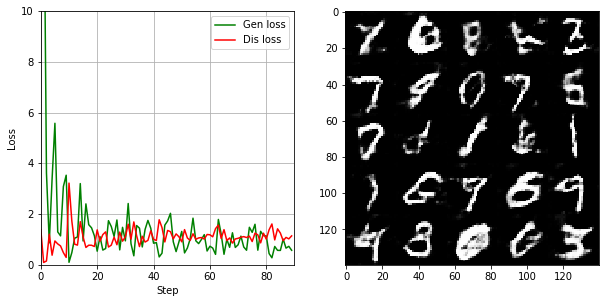

Epc: 1/2    Bat: 0910/1200    Dis Loss: 1.1611    Gen Loss: 0.5487    Time elaps: 00:02:18    Time remain: 00:03:46.
Epc: 1/2    Bat: 0920/1200    Dis Loss: 0.9817    Gen Loss: 1.0147    Time elaps: 00:02:20    Time remain: 00:03:45.
Epc: 1/2    Bat: 0930/1200    Dis Loss: 1.0317    Gen Loss: 0.7400    Time elaps: 00:02:21    Time remain: 00:03:43.
Epc: 1/2    Bat: 0940/1200    Dis Loss: 0.9518    Gen Loss: 1.6158    Time elaps: 00:02:23    Time remain: 00:03:42.
Epc: 1/2    Bat: 0950/1200    Dis Loss: 1.5487    Gen Loss: 0.3332    Time elaps: 00:02:24    Time remain: 00:03:40.
Epc: 1/2    Bat: 0960/1200    Dis Loss: 1.0107    Gen Loss: 0.8481    Time elaps: 00:02:26    Time remain: 00:03:39.
Epc: 1/2    Bat: 0970/1200    Dis Loss: 0.9225    Gen Loss: 0.8400    Time elaps: 00:02:27    Time remain: 00:03:37.
Epc: 1/2    Bat: 0980/1200    Dis Loss: 1.3322    Gen Loss: 1.6891    Time elaps: 00:02:28    Time remain: 00:03:35.
Epc: 1/2    Bat: 0990/1200    Dis Loss: 1.0515    Gen Loss: 1.11

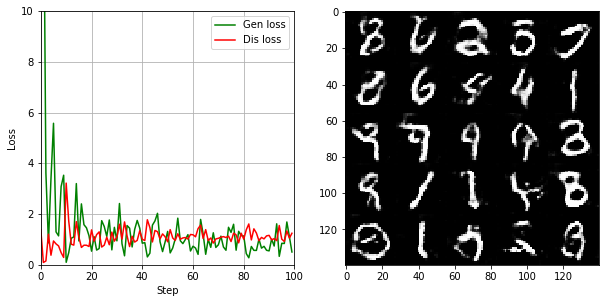

Epc: 1/2    Bat: 1010/1200    Dis Loss: 1.0084    Gen Loss: 1.2426    Time elaps: 00:02:33    Time remain: 00:03:31.
Epc: 1/2    Bat: 1020/1200    Dis Loss: 1.0733    Gen Loss: 0.8706    Time elaps: 00:02:35    Time remain: 00:03:30.
Epc: 1/2    Bat: 1030/1200    Dis Loss: 0.8516    Gen Loss: 1.1801    Time elaps: 00:02:36    Time remain: 00:03:28.
Epc: 1/2    Bat: 1040/1200    Dis Loss: 1.4088    Gen Loss: 0.4247    Time elaps: 00:02:38    Time remain: 00:03:26.
Epc: 1/2    Bat: 1050/1200    Dis Loss: 1.1739    Gen Loss: 0.7165    Time elaps: 00:02:39    Time remain: 00:03:25.
Epc: 1/2    Bat: 1060/1200    Dis Loss: 0.9522    Gen Loss: 0.7494    Time elaps: 00:02:41    Time remain: 00:03:23.
Epc: 1/2    Bat: 1070/1200    Dis Loss: 1.0975    Gen Loss: 0.6482    Time elaps: 00:02:42    Time remain: 00:03:22.
Epc: 1/2    Bat: 1080/1200    Dis Loss: 0.9627    Gen Loss: 1.1175    Time elaps: 00:02:44    Time remain: 00:03:20.
Epc: 1/2    Bat: 1090/1200    Dis Loss: 0.8945    Gen Loss: 0.86

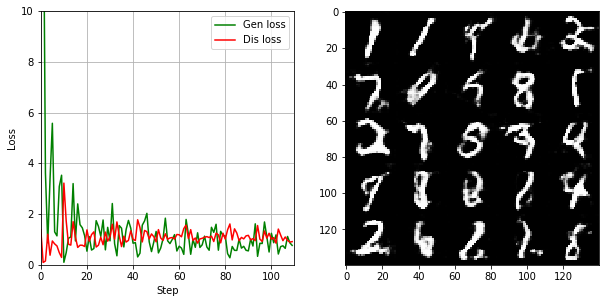

Epc: 1/2    Bat: 1110/1200    Dis Loss: 1.4102    Gen Loss: 0.4729    Time elaps: 00:02:48    Time remain: 00:03:16.
Epc: 1/2    Bat: 1120/1200    Dis Loss: 1.2513    Gen Loss: 0.5884    Time elaps: 00:02:50    Time remain: 00:03:14.
Epc: 1/2    Bat: 1130/1200    Dis Loss: 1.2561    Gen Loss: 0.5018    Time elaps: 00:02:51    Time remain: 00:03:13.
Epc: 1/2    Bat: 1140/1200    Dis Loss: 1.4483    Gen Loss: 0.3727    Time elaps: 00:02:53    Time remain: 00:03:11.
Epc: 1/2    Bat: 1150/1200    Dis Loss: 0.8460    Gen Loss: 1.0508    Time elaps: 00:02:54    Time remain: 00:03:10.
Epc: 1/2    Bat: 1160/1200    Dis Loss: 1.0815    Gen Loss: 0.5721    Time elaps: 00:02:56    Time remain: 00:03:08.
Epc: 1/2    Bat: 1170/1200    Dis Loss: 2.1589    Gen Loss: 0.1920    Time elaps: 00:02:57    Time remain: 00:03:06.
Epc: 1/2    Bat: 1180/1200    Dis Loss: 1.1442    Gen Loss: 0.6029    Time elaps: 00:02:59    Time remain: 00:03:05.
Epc: 1/2    Bat: 1190/1200    Dis Loss: 0.8362    Gen Loss: 1.09

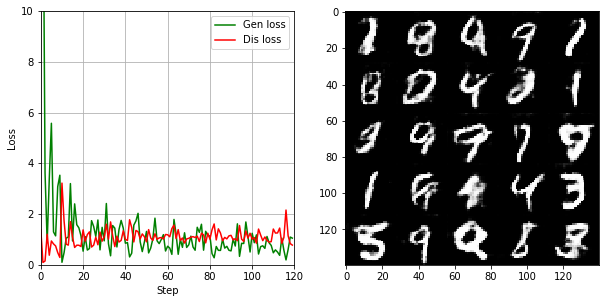

Epc: 2/2    Bat: 0010/1200    Dis Loss: 1.2339    Gen Loss: 0.4427    Time elaps: 00:03:04    Time remain: 00:03:01.
Epc: 2/2    Bat: 0020/1200    Dis Loss: 0.9111    Gen Loss: 1.5894    Time elaps: 00:03:05    Time remain: 00:02:59.
Epc: 2/2    Bat: 0030/1200    Dis Loss: 0.6752    Gen Loss: 1.1629    Time elaps: 00:03:07    Time remain: 00:02:58.
Epc: 2/2    Bat: 0040/1200    Dis Loss: 0.7666    Gen Loss: 1.0326    Time elaps: 00:03:08    Time remain: 00:02:56.
Epc: 2/2    Bat: 0050/1200    Dis Loss: 2.6066    Gen Loss: 4.2821    Time elaps: 00:03:10    Time remain: 00:02:54.
Epc: 2/2    Bat: 0060/1200    Dis Loss: 1.1065    Gen Loss: 1.5016    Time elaps: 00:03:11    Time remain: 00:02:53.
Epc: 2/2    Bat: 0070/1200    Dis Loss: 0.8462    Gen Loss: 0.9173    Time elaps: 00:03:13    Time remain: 00:02:51.
Epc: 2/2    Bat: 0080/1200    Dis Loss: 0.8426    Gen Loss: 2.6365    Time elaps: 00:03:14    Time remain: 00:02:50.
Epc: 2/2    Bat: 0090/1200    Dis Loss: 0.8920    Gen Loss: 0.75

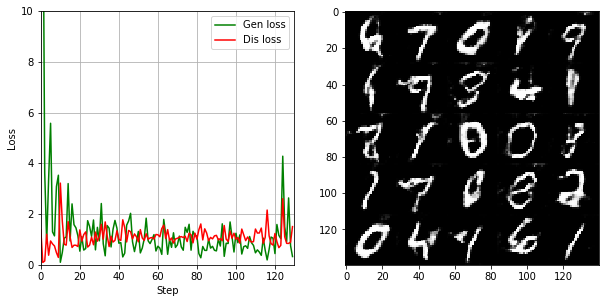

Epc: 2/2    Bat: 0110/1200    Dis Loss: 1.3125    Gen Loss: 2.3250    Time elaps: 00:03:19    Time remain: 00:02:45.
Epc: 2/2    Bat: 0120/1200    Dis Loss: 0.6187    Gen Loss: 1.8189    Time elaps: 00:03:20    Time remain: 00:02:44.
Epc: 2/2    Bat: 0130/1200    Dis Loss: 0.7631    Gen Loss: 1.8020    Time elaps: 00:03:22    Time remain: 00:02:42.
Epc: 2/2    Bat: 0140/1200    Dis Loss: 0.7995    Gen Loss: 1.2796    Time elaps: 00:03:23    Time remain: 00:02:41.
Epc: 2/2    Bat: 0150/1200    Dis Loss: 0.7016    Gen Loss: 0.9485    Time elaps: 00:03:25    Time remain: 00:02:39.
Epc: 2/2    Bat: 0160/1200    Dis Loss: 1.2660    Gen Loss: 0.4591    Time elaps: 00:03:26    Time remain: 00:02:38.
Epc: 2/2    Bat: 0170/1200    Dis Loss: 0.8788    Gen Loss: 1.6250    Time elaps: 00:03:28    Time remain: 00:02:36.
Epc: 2/2    Bat: 0180/1200    Dis Loss: 1.3568    Gen Loss: 1.2442    Time elaps: 00:03:29    Time remain: 00:02:34.
Epc: 2/2    Bat: 0190/1200    Dis Loss: 1.8182    Gen Loss: 0.25

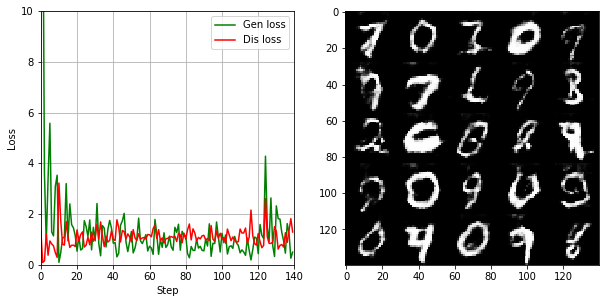

Epc: 2/2    Bat: 0210/1200    Dis Loss: 0.9519    Gen Loss: 0.8532    Time elaps: 00:03:34    Time remain: 00:02:30.
Epc: 2/2    Bat: 0220/1200    Dis Loss: 1.1816    Gen Loss: 0.5520    Time elaps: 00:03:35    Time remain: 00:02:28.
Epc: 2/2    Bat: 0230/1200    Dis Loss: 0.6899    Gen Loss: 1.4252    Time elaps: 00:03:37    Time remain: 00:02:27.
Epc: 2/2    Bat: 0240/1200    Dis Loss: 0.9592    Gen Loss: 2.0365    Time elaps: 00:03:38    Time remain: 00:02:25.
Epc: 2/2    Bat: 0250/1200    Dis Loss: 0.9819    Gen Loss: 0.8079    Time elaps: 00:03:40    Time remain: 00:02:24.
Epc: 2/2    Bat: 0260/1200    Dis Loss: 0.5430    Gen Loss: 1.3112    Time elaps: 00:03:41    Time remain: 00:02:22.
Epc: 2/2    Bat: 0270/1200    Dis Loss: 1.1665    Gen Loss: 0.8656    Time elaps: 00:03:43    Time remain: 00:02:21.
Epc: 2/2    Bat: 0280/1200    Dis Loss: 0.7439    Gen Loss: 1.1010    Time elaps: 00:03:44    Time remain: 00:02:19.
Epc: 2/2    Bat: 0290/1200    Dis Loss: 1.0428    Gen Loss: 0.88

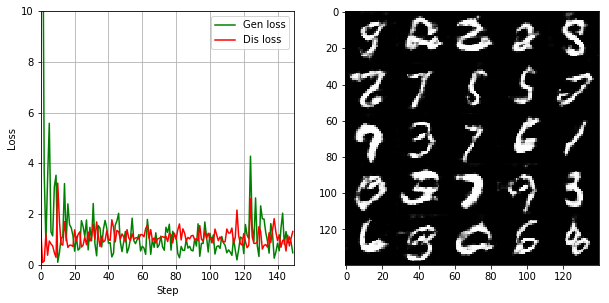

Epc: 2/2    Bat: 0310/1200    Dis Loss: 1.0230    Gen Loss: 0.7565    Time elaps: 00:03:49    Time remain: 00:02:15.
Epc: 2/2    Bat: 0320/1200    Dis Loss: 1.1445    Gen Loss: 2.6105    Time elaps: 00:03:50    Time remain: 00:02:13.
Epc: 2/2    Bat: 0330/1200    Dis Loss: 1.4012    Gen Loss: 0.4666    Time elaps: 00:03:52    Time remain: 00:02:12.
Epc: 2/2    Bat: 0340/1200    Dis Loss: 0.9243    Gen Loss: 1.4913    Time elaps: 00:03:53    Time remain: 00:02:10.
Epc: 2/2    Bat: 0350/1200    Dis Loss: 0.6177    Gen Loss: 1.6321    Time elaps: 00:03:55    Time remain: 00:02:08.
Epc: 2/2    Bat: 0360/1200    Dis Loss: 1.2167    Gen Loss: 0.4952    Time elaps: 00:03:56    Time remain: 00:02:07.
Epc: 2/2    Bat: 0370/1200    Dis Loss: 0.8248    Gen Loss: 0.8371    Time elaps: 00:03:58    Time remain: 00:02:05.
Epc: 2/2    Bat: 0380/1200    Dis Loss: 0.8002    Gen Loss: 1.6553    Time elaps: 00:03:59    Time remain: 00:02:04.
Epc: 2/2    Bat: 0390/1200    Dis Loss: 0.9949    Gen Loss: 0.88

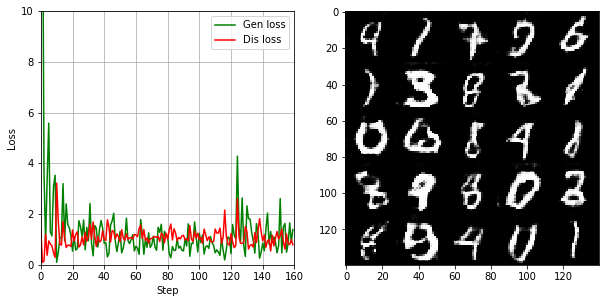

Epc: 2/2    Bat: 0410/1200    Dis Loss: 0.9934    Gen Loss: 0.6733    Time elaps: 00:04:04    Time remain: 00:01:59.
Epc: 2/2    Bat: 0420/1200    Dis Loss: 1.8641    Gen Loss: 0.3791    Time elaps: 00:04:05    Time remain: 00:01:58.
Epc: 2/2    Bat: 0430/1200    Dis Loss: 0.9263    Gen Loss: 0.9036    Time elaps: 00:04:07    Time remain: 00:01:56.
Epc: 2/2    Bat: 0440/1200    Dis Loss: 1.1084    Gen Loss: 0.5566    Time elaps: 00:04:08    Time remain: 00:01:55.
Epc: 2/2    Bat: 0450/1200    Dis Loss: 0.9431    Gen Loss: 2.7479    Time elaps: 00:04:10    Time remain: 00:01:53.
Epc: 2/2    Bat: 0460/1200    Dis Loss: 0.8330    Gen Loss: 0.9327    Time elaps: 00:04:11    Time remain: 00:01:52.
Epc: 2/2    Bat: 0470/1200    Dis Loss: 1.2403    Gen Loss: 0.5248    Time elaps: 00:04:13    Time remain: 00:01:50.
Epc: 2/2    Bat: 0480/1200    Dis Loss: 0.6540    Gen Loss: 1.1346    Time elaps: 00:04:14    Time remain: 00:01:49.
Epc: 2/2    Bat: 0490/1200    Dis Loss: 0.8287    Gen Loss: 0.93

Epc: 2/2    Bat: 0510/1200    Dis Loss: 1.1620    Gen Loss: 0.5569    Time elaps: 00:04:19    Time remain: 00:01:44.
Epc: 2/2    Bat: 0520/1200    Dis Loss: 1.1702    Gen Loss: 0.5503    Time elaps: 00:04:20    Time remain: 00:01:43.
Epc: 2/2    Bat: 0530/1200    Dis Loss: 0.5787    Gen Loss: 1.2574    Time elaps: 00:04:22    Time remain: 00:01:41.
Epc: 2/2    Bat: 0540/1200    Dis Loss: 0.6366    Gen Loss: 1.2574    Time elaps: 00:04:23    Time remain: 00:01:40.
Epc: 2/2    Bat: 0550/1200    Dis Loss: 1.5182    Gen Loss: 3.2439    Time elaps: 00:04:25    Time remain: 00:01:38.
Epc: 2/2    Bat: 0560/1200    Dis Loss: 1.3645    Gen Loss: 0.4447    Time elaps: 00:04:26    Time remain: 00:01:36.
Epc: 2/2    Bat: 0570/1200    Dis Loss: 0.9032    Gen Loss: 0.7380    Time elaps: 00:04:28    Time remain: 00:01:35.
Epc: 2/2    Bat: 0580/1200    Dis Loss: 1.3740    Gen Loss: 0.4383    Time elaps: 00:04:29    Time remain: 00:01:33.
Epc: 2/2    Bat: 0590/1200    Dis Loss: 0.7152    Gen Loss: 1.30

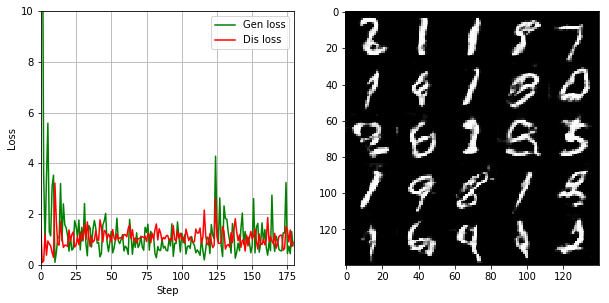

Epc: 2/2    Bat: 0610/1200    Dis Loss: 1.1596    Gen Loss: 0.5399    Time elaps: 00:04:34    Time remain: 00:01:29.
Epc: 2/2    Bat: 0620/1200    Dis Loss: 1.7393    Gen Loss: 0.3443    Time elaps: 00:04:35    Time remain: 00:01:27.
Epc: 2/2    Bat: 0630/1200    Dis Loss: 0.5958    Gen Loss: 1.4549    Time elaps: 00:04:37    Time remain: 00:01:26.
Epc: 2/2    Bat: 0640/1200    Dis Loss: 0.7774    Gen Loss: 1.1161    Time elaps: 00:04:38    Time remain: 00:01:24.
Epc: 2/2    Bat: 0650/1200    Dis Loss: 1.2347    Gen Loss: 0.4620    Time elaps: 00:04:40    Time remain: 00:01:23.
Epc: 2/2    Bat: 0660/1200    Dis Loss: 0.7649    Gen Loss: 0.9915    Time elaps: 00:04:41    Time remain: 00:01:21.
Epc: 2/2    Bat: 0670/1200    Dis Loss: 1.8729    Gen Loss: 2.5909    Time elaps: 00:04:43    Time remain: 00:01:20.
Epc: 2/2    Bat: 0680/1200    Dis Loss: 0.8206    Gen Loss: 1.1604    Time elaps: 00:04:44    Time remain: 00:01:18.
Epc: 2/2    Bat: 0690/1200    Dis Loss: 0.7942    Gen Loss: 1.05

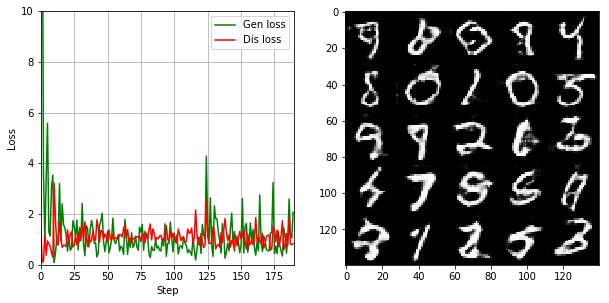

Epc: 2/2    Bat: 0710/1200    Dis Loss: 1.2499    Gen Loss: 0.5317    Time elaps: 00:04:49    Time remain: 00:01:14.
Epc: 2/2    Bat: 0720/1200    Dis Loss: 0.8041    Gen Loss: 1.2337    Time elaps: 00:04:50    Time remain: 00:01:12.
Epc: 2/2    Bat: 0730/1200    Dis Loss: 0.5681    Gen Loss: 1.5518    Time elaps: 00:04:52    Time remain: 00:01:11.
Epc: 2/2    Bat: 0740/1200    Dis Loss: 0.9934    Gen Loss: 1.6562    Time elaps: 00:04:53    Time remain: 00:01:09.
Epc: 2/2    Bat: 0750/1200    Dis Loss: 0.7259    Gen Loss: 1.1926    Time elaps: 00:04:55    Time remain: 00:01:08.
Epc: 2/2    Bat: 0760/1200    Dis Loss: 1.1796    Gen Loss: 0.6026    Time elaps: 00:04:56    Time remain: 00:01:06.
Epc: 2/2    Bat: 0770/1200    Dis Loss: 0.4552    Gen Loss: 1.4354    Time elaps: 00:04:58    Time remain: 00:01:05.
Epc: 2/2    Bat: 0780/1200    Dis Loss: 0.6807    Gen Loss: 1.1511    Time elaps: 00:04:59    Time remain: 00:01:03.
Epc: 2/2    Bat: 0790/1200    Dis Loss: 0.4412    Gen Loss: 1.64

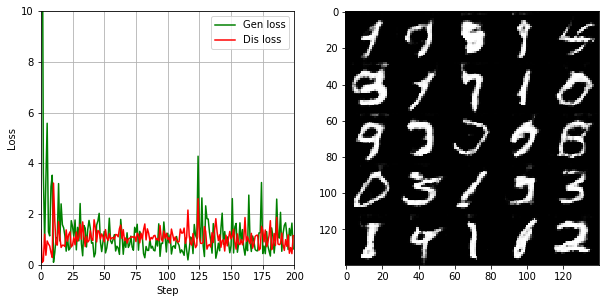

Epc: 2/2    Bat: 0810/1200    Dis Loss: 0.7836    Gen Loss: 0.9646    Time elaps: 00:05:04    Time remain: 00:00:59.
Epc: 2/2    Bat: 0820/1200    Dis Loss: 1.7767    Gen Loss: 0.4054    Time elaps: 00:05:05    Time remain: 00:00:57.
Epc: 2/2    Bat: 0830/1200    Dis Loss: 1.5127    Gen Loss: 0.3743    Time elaps: 00:05:07    Time remain: 00:00:55.
Epc: 2/2    Bat: 0840/1200    Dis Loss: 0.8029    Gen Loss: 0.8451    Time elaps: 00:05:08    Time remain: 00:00:54.
Epc: 2/2    Bat: 0850/1200    Dis Loss: 0.6126    Gen Loss: 1.2456    Time elaps: 00:05:10    Time remain: 00:00:52.
Epc: 2/2    Bat: 0860/1200    Dis Loss: 0.7750    Gen Loss: 0.9682    Time elaps: 00:05:11    Time remain: 00:00:51.
Epc: 2/2    Bat: 0870/1200    Dis Loss: 2.0786    Gen Loss: 0.3143    Time elaps: 00:05:13    Time remain: 00:00:49.
Epc: 2/2    Bat: 0880/1200    Dis Loss: 1.0627    Gen Loss: 0.6790    Time elaps: 00:05:14    Time remain: 00:00:48.
Epc: 2/2    Bat: 0890/1200    Dis Loss: 1.0481    Gen Loss: 0.64

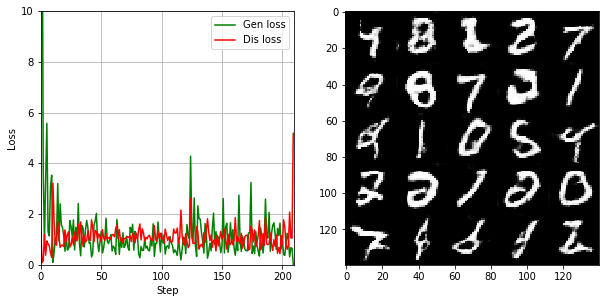

Epc: 2/2    Bat: 0910/1200    Dis Loss: 0.9170    Gen Loss: 0.8692    Time elaps: 00:05:19    Time remain: 00:00:43.
Epc: 2/2    Bat: 0920/1200    Dis Loss: 0.7885    Gen Loss: 0.8966    Time elaps: 00:05:20    Time remain: 00:00:42.
Epc: 2/2    Bat: 0930/1200    Dis Loss: 0.5830    Gen Loss: 1.7449    Time elaps: 00:05:22    Time remain: 00:00:40.
Epc: 2/2    Bat: 0940/1200    Dis Loss: 0.9545    Gen Loss: 0.7382    Time elaps: 00:05:23    Time remain: 00:00:39.
Epc: 2/2    Bat: 0950/1200    Dis Loss: 0.6234    Gen Loss: 1.2091    Time elaps: 00:05:25    Time remain: 00:00:37.
Epc: 2/2    Bat: 0960/1200    Dis Loss: 0.7809    Gen Loss: 1.0866    Time elaps: 00:05:26    Time remain: 00:00:36.
Epc: 2/2    Bat: 0970/1200    Dis Loss: 2.0861    Gen Loss: 0.2463    Time elaps: 00:05:27    Time remain: 00:00:34.
Epc: 2/2    Bat: 0980/1200    Dis Loss: 0.6755    Gen Loss: 2.3053    Time elaps: 00:05:29    Time remain: 00:00:33.
Epc: 2/2    Bat: 0990/1200    Dis Loss: 0.8724    Gen Loss: 2.08

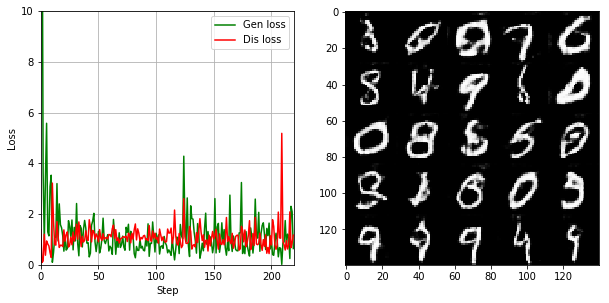

Epc: 2/2    Bat: 1010/1200    Dis Loss: 0.5136    Gen Loss: 1.4492    Time elaps: 00:05:34    Time remain: 00:00:28.
Epc: 2/2    Bat: 1020/1200    Dis Loss: 1.2487    Gen Loss: 0.5799    Time elaps: 00:05:35    Time remain: 00:00:27.
Epc: 2/2    Bat: 1030/1200    Dis Loss: 1.5652    Gen Loss: 0.4472    Time elaps: 00:05:37    Time remain: 00:00:25.
Epc: 2/2    Bat: 1040/1200    Dis Loss: 1.0750    Gen Loss: 0.6233    Time elaps: 00:05:38    Time remain: 00:00:24.
Epc: 2/2    Bat: 1050/1200    Dis Loss: 0.8905    Gen Loss: 0.7826    Time elaps: 00:05:40    Time remain: 00:00:22.
Epc: 2/2    Bat: 1060/1200    Dis Loss: 0.8856    Gen Loss: 0.8072    Time elaps: 00:05:41    Time remain: 00:00:21.
Epc: 2/2    Bat: 1070/1200    Dis Loss: 0.6944    Gen Loss: 1.0679    Time elaps: 00:05:42    Time remain: 00:00:19.
Epc: 2/2    Bat: 1080/1200    Dis Loss: 0.8550    Gen Loss: 0.7686    Time elaps: 00:05:44    Time remain: 00:00:18.
Epc: 2/2    Bat: 1090/1200    Dis Loss: 1.1381    Gen Loss: 3.26

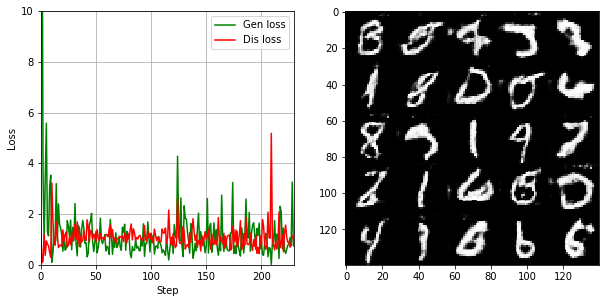

Epc: 2/2    Bat: 1110/1200    Dis Loss: 0.9452    Gen Loss: 1.2145    Time elaps: 00:05:49    Time remain: 00:00:13.
Epc: 2/2    Bat: 1120/1200    Dis Loss: 1.2079    Gen Loss: 0.6338    Time elaps: 00:05:50    Time remain: 00:00:12.
Epc: 2/2    Bat: 1130/1200    Dis Loss: 0.7418    Gen Loss: 0.9518    Time elaps: 00:05:52    Time remain: 00:00:10.
Epc: 2/2    Bat: 1140/1200    Dis Loss: 1.4913    Gen Loss: 0.5928    Time elaps: 00:05:53    Time remain: 00:00:09.
Epc: 2/2    Bat: 1150/1200    Dis Loss: 1.6519    Gen Loss: 0.3755    Time elaps: 00:05:55    Time remain: 00:00:07.
Epc: 2/2    Bat: 1160/1200    Dis Loss: 0.7686    Gen Loss: 0.9216    Time elaps: 00:05:56    Time remain: 00:00:06.
Epc: 2/2    Bat: 1170/1200    Dis Loss: 0.7124    Gen Loss: 1.4410    Time elaps: 00:05:57    Time remain: 00:00:04.
Epc: 2/2    Bat: 1180/1200    Dis Loss: 1.8647    Gen Loss: 4.1134    Time elaps: 00:05:59    Time remain: 00:00:03.
Epc: 2/2    Bat: 1190/1200    Dis Loss: 0.6600    Gen Loss: 1.08

In [195]:
batch_size = 50
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches, mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epc: 1/1    Bat: 0010/3165    Dis Loss: 0.2260    Gen Loss: 6.3894    Time elaps: 00:00:02    Time remain: 00:13:03.
Epc: 1/1    Bat: 0020/3165    Dis Loss: 0.2079    Gen Loss: 11.8194    Time elaps: 00:00:04    Time remain: 00:11:56.
Epc: 1/1    Bat: 0030/3165    Dis Loss: 0.0524    Gen Loss: 7.1790    Time elaps: 00:00:06    Time remain: 00:11:33.
Epc: 1/1    Bat: 0040/3165    Dis Loss: 0.0546    Gen Loss: 8.6430    Time elaps: 00:00:08    Time remain: 00:11:20.
Epc: 1/1    Bat: 0050/3165    Dis Loss: 0.1206    Gen Loss: 7.4353    Time elaps: 00:00:10    Time remain: 00:11:12.
Epc: 1/1    Bat: 0060/3165    Dis Loss: 0.0226    Gen Loss: 10.9963    Time elaps: 00:00:12    Time remain: 00:11:05.
Epc: 1/1    Bat: 0070/3165    Dis Loss: 0.1625    Gen Loss: 9.2119    Time elaps: 00:00:14    Time remain: 00:11:00.
Epc: 1/1    Bat: 0080/3165    Dis Loss: 0.5062    Gen Loss: 10.6393    Time elaps: 00:00:17    Time remain: 00:10:56.
Epc: 1/1    Bat: 0090/3165    Dis Loss: 0.5729    Gen Loss: 1

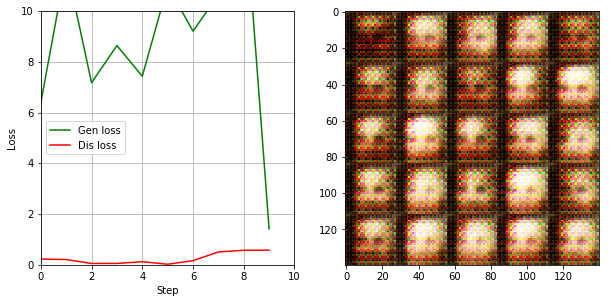

Epc: 1/1    Bat: 0110/3165    Dis Loss: 0.5091    Gen Loss: 1.2067    Time elaps: 00:00:23    Time remain: 00:10:54.
Epc: 1/1    Bat: 0120/3165    Dis Loss: 1.2746    Gen Loss: 0.7130    Time elaps: 00:00:25    Time remain: 00:10:51.
Epc: 1/1    Bat: 0130/3165    Dis Loss: 0.3913    Gen Loss: 2.8104    Time elaps: 00:00:27    Time remain: 00:10:47.
Epc: 1/1    Bat: 0140/3165    Dis Loss: 0.6252    Gen Loss: 1.1731    Time elaps: 00:00:29    Time remain: 00:10:44.
Epc: 1/1    Bat: 0150/3165    Dis Loss: 0.7321    Gen Loss: 1.1900    Time elaps: 00:00:31    Time remain: 00:10:41.
Epc: 1/1    Bat: 0160/3165    Dis Loss: 0.4502    Gen Loss: 2.9470    Time elaps: 00:00:33    Time remain: 00:10:38.
Epc: 1/1    Bat: 0170/3165    Dis Loss: 2.2916    Gen Loss: 8.1359    Time elaps: 00:00:36    Time remain: 00:10:35.
Epc: 1/1    Bat: 0180/3165    Dis Loss: 0.5809    Gen Loss: 1.4612    Time elaps: 00:00:38    Time remain: 00:10:32.
Epc: 1/1    Bat: 0190/3165    Dis Loss: 0.2710    Gen Loss: 3.51

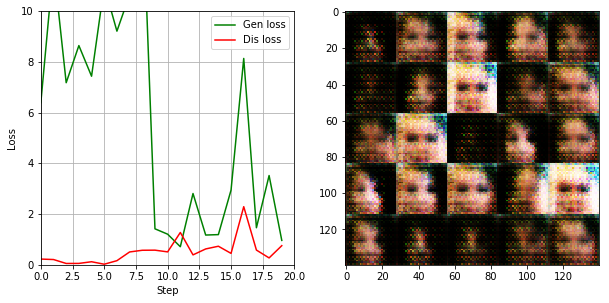

Epc: 1/1    Bat: 0210/3165    Dis Loss: 1.6824    Gen Loss: 0.4428    Time elaps: 00:00:44    Time remain: 00:10:28.
Epc: 1/1    Bat: 0220/3165    Dis Loss: 0.6434    Gen Loss: 2.3980    Time elaps: 00:00:46    Time remain: 00:10:26.
Epc: 1/1    Bat: 0230/3165    Dis Loss: 1.1361    Gen Loss: 0.7038    Time elaps: 00:00:48    Time remain: 00:10:23.
Epc: 1/1    Bat: 0240/3165    Dis Loss: 1.0894    Gen Loss: 0.5846    Time elaps: 00:00:50    Time remain: 00:10:20.
Epc: 1/1    Bat: 0250/3165    Dis Loss: 2.9556    Gen Loss: 7.3607    Time elaps: 00:00:52    Time remain: 00:10:17.
Epc: 1/1    Bat: 0260/3165    Dis Loss: 1.7702    Gen Loss: 0.2407    Time elaps: 00:00:55    Time remain: 00:10:15.
Epc: 1/1    Bat: 0270/3165    Dis Loss: 1.3644    Gen Loss: 0.3575    Time elaps: 00:00:57    Time remain: 00:10:12.
Epc: 1/1    Bat: 0280/3165    Dis Loss: 0.5066    Gen Loss: 1.7306    Time elaps: 00:00:59    Time remain: 00:10:10.
Epc: 1/1    Bat: 0290/3165    Dis Loss: 0.4680    Gen Loss: 1.35

Epc: 1/1    Bat: 0310/3165    Dis Loss: 1.2235    Gen Loss: 0.4901    Time elaps: 00:01:05    Time remain: 00:10:05.
Epc: 1/1    Bat: 0320/3165    Dis Loss: 0.4858    Gen Loss: 2.1412    Time elaps: 00:01:07    Time remain: 00:10:03.
Epc: 1/1    Bat: 0330/3165    Dis Loss: 1.1209    Gen Loss: 0.7258    Time elaps: 00:01:09    Time remain: 00:10:00.
Epc: 1/1    Bat: 0340/3165    Dis Loss: 0.4686    Gen Loss: 2.6040    Time elaps: 00:01:12    Time remain: 00:09:58.
Epc: 1/1    Bat: 0350/3165    Dis Loss: 0.9854    Gen Loss: 0.8319    Time elaps: 00:01:14    Time remain: 00:09:56.
Epc: 1/1    Bat: 0360/3165    Dis Loss: 0.7610    Gen Loss: 1.0097    Time elaps: 00:01:16    Time remain: 00:09:53.
Epc: 1/1    Bat: 0370/3165    Dis Loss: 1.3163    Gen Loss: 0.4017    Time elaps: 00:01:18    Time remain: 00:09:51.
Epc: 1/1    Bat: 0380/3165    Dis Loss: 0.3663    Gen Loss: 2.0453    Time elaps: 00:01:20    Time remain: 00:09:48.
Epc: 1/1    Bat: 0390/3165    Dis Loss: 2.1445    Gen Loss: 0.16

Epc: 1/1    Bat: 0410/3165    Dis Loss: 0.9755    Gen Loss: 0.6451    Time elaps: 00:01:27    Time remain: 00:09:46.
Epc: 1/1    Bat: 0420/3165    Dis Loss: 0.5989    Gen Loss: 3.6416    Time elaps: 00:01:29    Time remain: 00:09:43.
Epc: 1/1    Bat: 0430/3165    Dis Loss: 0.3438    Gen Loss: 2.5892    Time elaps: 00:01:31    Time remain: 00:09:41.
Epc: 1/1    Bat: 0440/3165    Dis Loss: 0.4178    Gen Loss: 1.9535    Time elaps: 00:01:33    Time remain: 00:09:39.
Epc: 1/1    Bat: 0450/3165    Dis Loss: 0.4830    Gen Loss: 1.2409    Time elaps: 00:01:35    Time remain: 00:09:36.
Epc: 1/1    Bat: 0460/3165    Dis Loss: 0.2057    Gen Loss: 3.9351    Time elaps: 00:01:37    Time remain: 00:09:34.
Epc: 1/1    Bat: 0470/3165    Dis Loss: 0.7796    Gen Loss: 1.0577    Time elaps: 00:01:39    Time remain: 00:09:32.
Epc: 1/1    Bat: 0480/3165    Dis Loss: 0.6929    Gen Loss: 0.8786    Time elaps: 00:01:41    Time remain: 00:09:29.
Epc: 1/1    Bat: 0490/3165    Dis Loss: 0.4910    Gen Loss: 2.63

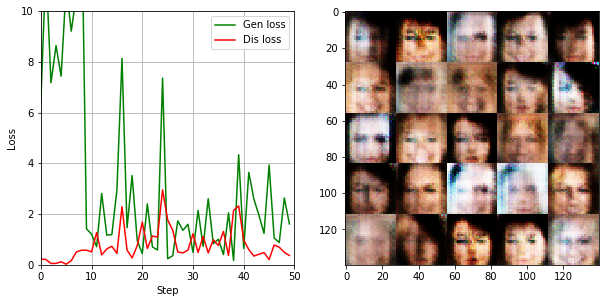

Epc: 1/1    Bat: 0510/3165    Dis Loss: 0.2697    Gen Loss: 2.8690    Time elaps: 00:01:48    Time remain: 00:09:24.
Epc: 1/1    Bat: 0520/3165    Dis Loss: 0.5561    Gen Loss: 1.0706    Time elaps: 00:01:50    Time remain: 00:09:22.
Epc: 1/1    Bat: 0530/3165    Dis Loss: 0.7211    Gen Loss: 1.0199    Time elaps: 00:01:52    Time remain: 00:09:20.
Epc: 1/1    Bat: 0540/3165    Dis Loss: 0.4270    Gen Loss: 1.6441    Time elaps: 00:01:54    Time remain: 00:09:17.
Epc: 1/1    Bat: 0550/3165    Dis Loss: 0.6607    Gen Loss: 1.0055    Time elaps: 00:01:56    Time remain: 00:09:15.
Epc: 1/1    Bat: 0560/3165    Dis Loss: 0.5360    Gen Loss: 1.2194    Time elaps: 00:01:58    Time remain: 00:09:13.
Epc: 1/1    Bat: 0570/3165    Dis Loss: 0.4066    Gen Loss: 2.5858    Time elaps: 00:02:00    Time remain: 00:09:10.
Epc: 1/1    Bat: 0580/3165    Dis Loss: 0.7682    Gen Loss: 0.8511    Time elaps: 00:02:03    Time remain: 00:09:08.
Epc: 1/1    Bat: 0590/3165    Dis Loss: 2.0497    Gen Loss: 0.17

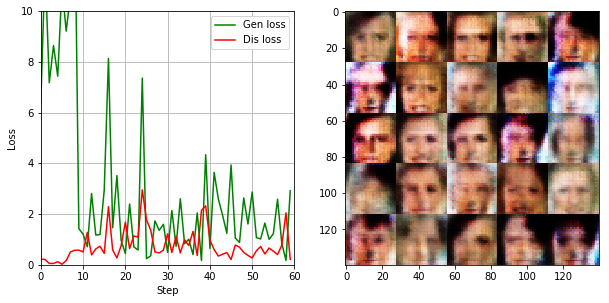

Epc: 1/1    Bat: 0610/3165    Dis Loss: 1.4577    Gen Loss: 5.4596    Time elaps: 00:02:09    Time remain: 00:09:02.
Epc: 1/1    Bat: 0620/3165    Dis Loss: 1.0079    Gen Loss: 3.5836    Time elaps: 00:02:11    Time remain: 00:09:00.
Epc: 1/1    Bat: 0630/3165    Dis Loss: 1.1683    Gen Loss: 4.2977    Time elaps: 00:02:13    Time remain: 00:08:58.
Epc: 1/1    Bat: 0640/3165    Dis Loss: 0.4389    Gen Loss: 1.5345    Time elaps: 00:02:15    Time remain: 00:08:56.
Epc: 1/1    Bat: 0650/3165    Dis Loss: 2.5878    Gen Loss: 6.2285    Time elaps: 00:02:17    Time remain: 00:08:53.
Epc: 1/1    Bat: 0660/3165    Dis Loss: 0.5754    Gen Loss: 3.1235    Time elaps: 00:02:19    Time remain: 00:08:51.
Epc: 1/1    Bat: 0670/3165    Dis Loss: 0.8452    Gen Loss: 0.7947    Time elaps: 00:02:22    Time remain: 00:08:49.
Epc: 1/1    Bat: 0680/3165    Dis Loss: 0.1449    Gen Loss: 3.5963    Time elaps: 00:02:24    Time remain: 00:08:46.
Epc: 1/1    Bat: 0690/3165    Dis Loss: 0.3556    Gen Loss: 1.99

Epc: 1/1    Bat: 0710/3165    Dis Loss: 2.1621    Gen Loss: 5.0126    Time elaps: 00:02:30    Time remain: 00:08:41.
Epc: 1/1    Bat: 0720/3165    Dis Loss: 1.2455    Gen Loss: 4.3830    Time elaps: 00:02:32    Time remain: 00:08:39.
Epc: 1/1    Bat: 0730/3165    Dis Loss: 0.4893    Gen Loss: 1.4433    Time elaps: 00:02:34    Time remain: 00:08:36.
Epc: 1/1    Bat: 0740/3165    Dis Loss: 0.7033    Gen Loss: 1.0081    Time elaps: 00:02:36    Time remain: 00:08:34.
Epc: 1/1    Bat: 0750/3165    Dis Loss: 0.6733    Gen Loss: 0.9510    Time elaps: 00:02:39    Time remain: 00:08:32.
Epc: 1/1    Bat: 0760/3165    Dis Loss: 0.8478    Gen Loss: 0.7496    Time elaps: 00:02:41    Time remain: 00:08:30.
Epc: 1/1    Bat: 0770/3165    Dis Loss: 0.1866    Gen Loss: 3.2284    Time elaps: 00:02:43    Time remain: 00:08:27.
Epc: 1/1    Bat: 0780/3165    Dis Loss: 0.6641    Gen Loss: 1.0219    Time elaps: 00:02:45    Time remain: 00:08:25.
Epc: 1/1    Bat: 0790/3165    Dis Loss: 0.8376    Gen Loss: 3.27

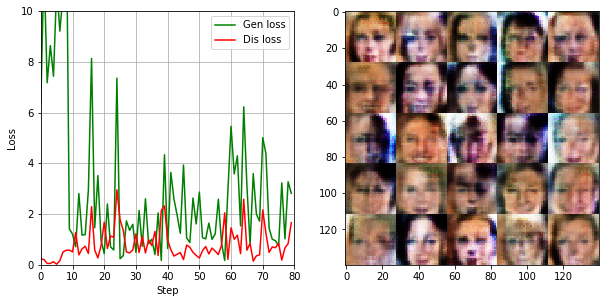

Epc: 1/1    Bat: 0810/3165    Dis Loss: 0.8263    Gen Loss: 1.2213    Time elaps: 00:02:51    Time remain: 00:08:19.
Epc: 1/1    Bat: 0820/3165    Dis Loss: 0.6730    Gen Loss: 1.6255    Time elaps: 00:02:53    Time remain: 00:08:17.
Epc: 1/1    Bat: 0830/3165    Dis Loss: 0.5106    Gen Loss: 2.1931    Time elaps: 00:02:56    Time remain: 00:08:15.
Epc: 1/1    Bat: 0840/3165    Dis Loss: 0.8750    Gen Loss: 0.9958    Time elaps: 00:02:58    Time remain: 00:08:13.
Epc: 1/1    Bat: 0850/3165    Dis Loss: 0.6400    Gen Loss: 1.6876    Time elaps: 00:03:00    Time remain: 00:08:11.
Epc: 1/1    Bat: 0860/3165    Dis Loss: 0.4080    Gen Loss: 1.9158    Time elaps: 00:03:02    Time remain: 00:08:08.
Epc: 1/1    Bat: 0870/3165    Dis Loss: 0.4789    Gen Loss: 2.0332    Time elaps: 00:03:04    Time remain: 00:08:06.
Epc: 1/1    Bat: 0880/3165    Dis Loss: 0.8400    Gen Loss: 1.2219    Time elaps: 00:03:06    Time remain: 00:08:04.
Epc: 1/1    Bat: 0890/3165    Dis Loss: 0.5182    Gen Loss: 4.98

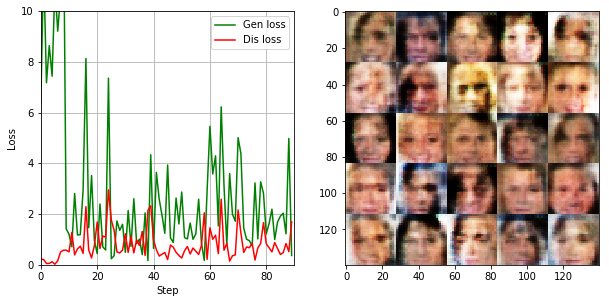

Epc: 1/1    Bat: 0910/3165    Dis Loss: 0.6976    Gen Loss: 2.3923    Time elaps: 00:03:13    Time remain: 00:07:58.
Epc: 1/1    Bat: 0920/3165    Dis Loss: 0.3023    Gen Loss: 2.7743    Time elaps: 00:03:15    Time remain: 00:07:56.
Epc: 1/1    Bat: 0930/3165    Dis Loss: 0.3608    Gen Loss: 2.9283    Time elaps: 00:03:17    Time remain: 00:07:54.
Epc: 1/1    Bat: 0940/3165    Dis Loss: 1.2357    Gen Loss: 0.5202    Time elaps: 00:03:19    Time remain: 00:07:51.
Epc: 1/1    Bat: 0950/3165    Dis Loss: 1.1864    Gen Loss: 0.5601    Time elaps: 00:03:21    Time remain: 00:07:49.
Epc: 1/1    Bat: 0960/3165    Dis Loss: 0.8100    Gen Loss: 0.8679    Time elaps: 00:03:23    Time remain: 00:07:47.
Epc: 1/1    Bat: 0970/3165    Dis Loss: 0.4304    Gen Loss: 2.3479    Time elaps: 00:03:25    Time remain: 00:07:45.
Epc: 1/1    Bat: 0980/3165    Dis Loss: 0.6466    Gen Loss: 2.4964    Time elaps: 00:03:27    Time remain: 00:07:43.
Epc: 1/1    Bat: 0990/3165    Dis Loss: 0.4531    Gen Loss: 1.57

Epc: 1/1    Bat: 1010/3165    Dis Loss: 0.5374    Gen Loss: 1.3048    Time elaps: 00:03:34    Time remain: 00:07:37.
Epc: 1/1    Bat: 1020/3165    Dis Loss: 0.6741    Gen Loss: 1.0961    Time elaps: 00:03:36    Time remain: 00:07:35.
Epc: 1/1    Bat: 1030/3165    Dis Loss: 0.3320    Gen Loss: 1.9370    Time elaps: 00:03:38    Time remain: 00:07:32.
Epc: 1/1    Bat: 1040/3165    Dis Loss: 0.3815    Gen Loss: 2.3806    Time elaps: 00:03:40    Time remain: 00:07:30.
Epc: 1/1    Bat: 1050/3165    Dis Loss: 0.2035    Gen Loss: 2.4838    Time elaps: 00:03:42    Time remain: 00:07:28.
Epc: 1/1    Bat: 1060/3165    Dis Loss: 0.7738    Gen Loss: 2.5993    Time elaps: 00:03:44    Time remain: 00:07:26.
Epc: 1/1    Bat: 1070/3165    Dis Loss: 1.1330    Gen Loss: 6.7308    Time elaps: 00:03:46    Time remain: 00:07:24.
Epc: 1/1    Bat: 1080/3165    Dis Loss: 0.5975    Gen Loss: 2.7865    Time elaps: 00:03:48    Time remain: 00:07:21.
Epc: 1/1    Bat: 1090/3165    Dis Loss: 0.1662    Gen Loss: 2.73

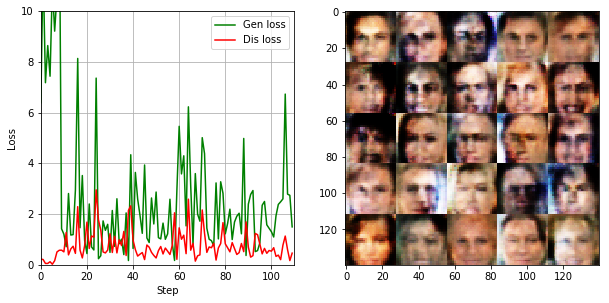

Epc: 1/1    Bat: 1110/3165    Dis Loss: 0.4023    Gen Loss: 3.3233    Time elaps: 00:03:55    Time remain: 00:07:15.
Epc: 1/1    Bat: 1120/3165    Dis Loss: 0.4762    Gen Loss: 1.2521    Time elaps: 00:03:57    Time remain: 00:07:13.
Epc: 1/1    Bat: 1130/3165    Dis Loss: 0.4700    Gen Loss: 1.4602    Time elaps: 00:03:59    Time remain: 00:07:11.
Epc: 1/1    Bat: 1140/3165    Dis Loss: 1.6661    Gen Loss: 0.3261    Time elaps: 00:04:01    Time remain: 00:07:09.
Epc: 1/1    Bat: 1150/3165    Dis Loss: 0.5993    Gen Loss: 2.1813    Time elaps: 00:04:03    Time remain: 00:07:07.
Epc: 1/1    Bat: 1160/3165    Dis Loss: 1.0182    Gen Loss: 0.6539    Time elaps: 00:04:05    Time remain: 00:07:04.
Epc: 1/1    Bat: 1170/3165    Dis Loss: 0.3149    Gen Loss: 2.9526    Time elaps: 00:04:07    Time remain: 00:07:02.
Epc: 1/1    Bat: 1180/3165    Dis Loss: 0.9919    Gen Loss: 3.1501    Time elaps: 00:04:09    Time remain: 00:07:00.
Epc: 1/1    Bat: 1190/3165    Dis Loss: 0.6556    Gen Loss: 1.00

Epc: 1/1    Bat: 1210/3165    Dis Loss: 0.1752    Gen Loss: 3.1256    Time elaps: 00:04:16    Time remain: 00:06:54.
Epc: 1/1    Bat: 1220/3165    Dis Loss: 0.3015    Gen Loss: 3.1957    Time elaps: 00:04:18    Time remain: 00:06:52.
Epc: 1/1    Bat: 1230/3165    Dis Loss: 0.9823    Gen Loss: 4.2194    Time elaps: 00:04:20    Time remain: 00:06:50.
Epc: 1/1    Bat: 1240/3165    Dis Loss: 1.1882    Gen Loss: 0.6141    Time elaps: 00:04:22    Time remain: 00:06:48.
Epc: 1/1    Bat: 1250/3165    Dis Loss: 1.0258    Gen Loss: 2.3523    Time elaps: 00:04:24    Time remain: 00:06:45.
Epc: 1/1    Bat: 1260/3165    Dis Loss: 0.9409    Gen Loss: 1.2435    Time elaps: 00:04:26    Time remain: 00:06:43.
Epc: 1/1    Bat: 1270/3165    Dis Loss: 1.1009    Gen Loss: 0.6640    Time elaps: 00:04:29    Time remain: 00:06:41.
Epc: 1/1    Bat: 1280/3165    Dis Loss: 0.3679    Gen Loss: 1.8518    Time elaps: 00:04:31    Time remain: 00:06:39.
Epc: 1/1    Bat: 1290/3165    Dis Loss: 0.8473    Gen Loss: 0.95

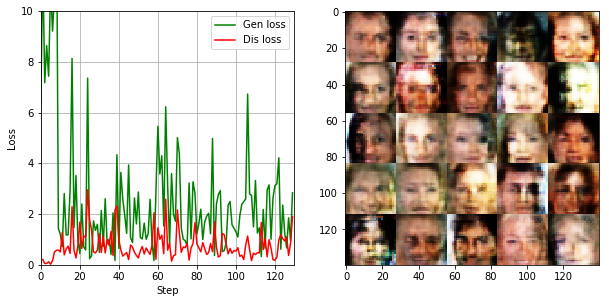

Epc: 1/1    Bat: 1310/3165    Dis Loss: 0.9905    Gen Loss: 0.8001    Time elaps: 00:04:37    Time remain: 00:06:33.
Epc: 1/1    Bat: 1320/3165    Dis Loss: 0.7766    Gen Loss: 1.1862    Time elaps: 00:04:39    Time remain: 00:06:31.
Epc: 1/1    Bat: 1330/3165    Dis Loss: 0.8620    Gen Loss: 0.9667    Time elaps: 00:04:41    Time remain: 00:06:29.
Epc: 1/1    Bat: 1340/3165    Dis Loss: 1.7583    Gen Loss: 4.5004    Time elaps: 00:04:43    Time remain: 00:06:26.
Epc: 1/1    Bat: 1350/3165    Dis Loss: 0.6234    Gen Loss: 1.8852    Time elaps: 00:04:46    Time remain: 00:06:24.
Epc: 1/1    Bat: 1360/3165    Dis Loss: 0.8575    Gen Loss: 0.9066    Time elaps: 00:04:48    Time remain: 00:06:22.
Epc: 1/1    Bat: 1370/3165    Dis Loss: 1.0053    Gen Loss: 0.7298    Time elaps: 00:04:50    Time remain: 00:06:20.
Epc: 1/1    Bat: 1380/3165    Dis Loss: 0.5008    Gen Loss: 2.7511    Time elaps: 00:04:52    Time remain: 00:06:18.
Epc: 1/1    Bat: 1390/3165    Dis Loss: 1.2220    Gen Loss: 0.56

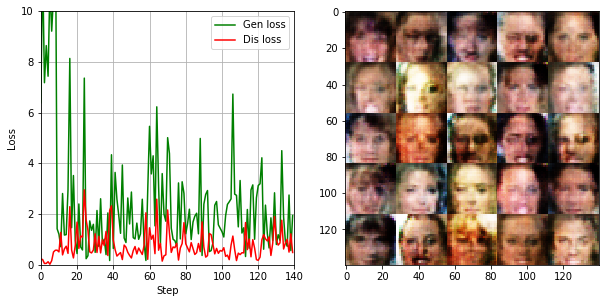

Epc: 1/1    Bat: 1410/3165    Dis Loss: 0.3607    Gen Loss: 1.7084    Time elaps: 00:04:58    Time remain: 00:06:12.
Epc: 1/1    Bat: 1420/3165    Dis Loss: 0.8438    Gen Loss: 3.1561    Time elaps: 00:05:01    Time remain: 00:06:10.
Epc: 1/1    Bat: 1430/3165    Dis Loss: 0.8283    Gen Loss: 0.8716    Time elaps: 00:05:03    Time remain: 00:06:07.
Epc: 1/1    Bat: 1440/3165    Dis Loss: 0.3803    Gen Loss: 1.6701    Time elaps: 00:05:05    Time remain: 00:06:05.
Epc: 1/1    Bat: 1450/3165    Dis Loss: 0.3336    Gen Loss: 2.0395    Time elaps: 00:05:07    Time remain: 00:06:03.
Epc: 1/1    Bat: 1460/3165    Dis Loss: 0.2418    Gen Loss: 3.1844    Time elaps: 00:05:09    Time remain: 00:06:01.
Epc: 1/1    Bat: 1470/3165    Dis Loss: 1.0588    Gen Loss: 0.6110    Time elaps: 00:05:11    Time remain: 00:05:59.
Epc: 1/1    Bat: 1480/3165    Dis Loss: 1.4609    Gen Loss: 3.8141    Time elaps: 00:05:13    Time remain: 00:05:57.
Epc: 1/1    Bat: 1490/3165    Dis Loss: 1.8228    Gen Loss: 0.28

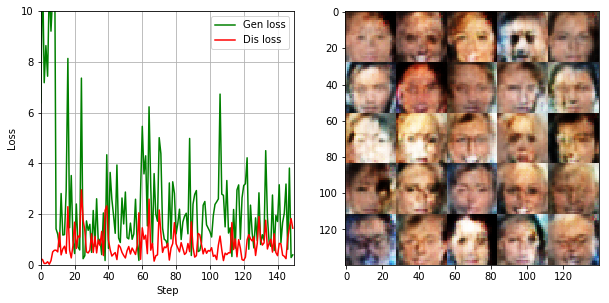

Epc: 1/1    Bat: 1510/3165    Dis Loss: 0.8563    Gen Loss: 0.8853    Time elaps: 00:05:20    Time remain: 00:05:50.
Epc: 1/1    Bat: 1520/3165    Dis Loss: 0.3146    Gen Loss: 1.8682    Time elaps: 00:05:22    Time remain: 00:05:48.
Epc: 1/1    Bat: 1530/3165    Dis Loss: 0.6101    Gen Loss: 1.4558    Time elaps: 00:05:24    Time remain: 00:05:46.
Epc: 1/1    Bat: 1540/3165    Dis Loss: 0.9043    Gen Loss: 0.6811    Time elaps: 00:05:26    Time remain: 00:05:44.
Epc: 1/1    Bat: 1550/3165    Dis Loss: 0.5250    Gen Loss: 1.7040    Time elaps: 00:05:28    Time remain: 00:05:42.
Epc: 1/1    Bat: 1560/3165    Dis Loss: 0.5090    Gen Loss: 1.9325    Time elaps: 00:05:30    Time remain: 00:05:40.
Epc: 1/1    Bat: 1570/3165    Dis Loss: 0.4968    Gen Loss: 4.0643    Time elaps: 00:05:32    Time remain: 00:05:38.
Epc: 1/1    Bat: 1580/3165    Dis Loss: 0.5196    Gen Loss: 1.4424    Time elaps: 00:05:34    Time remain: 00:05:35.
Epc: 1/1    Bat: 1590/3165    Dis Loss: 0.2793    Gen Loss: 2.02

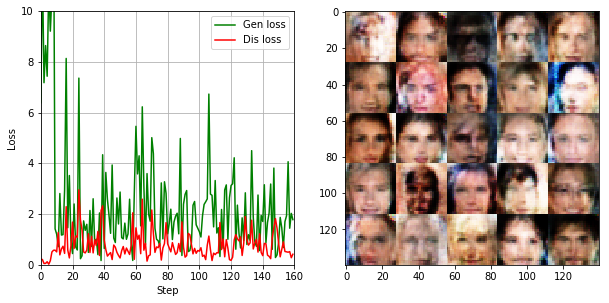

Epc: 1/1    Bat: 1610/3165    Dis Loss: 0.7307    Gen Loss: 0.9679    Time elaps: 00:05:41    Time remain: 00:05:29.
Epc: 1/1    Bat: 1620/3165    Dis Loss: 0.5383    Gen Loss: 1.2484    Time elaps: 00:05:43    Time remain: 00:05:27.
Epc: 1/1    Bat: 1630/3165    Dis Loss: 0.4772    Gen Loss: 1.4111    Time elaps: 00:05:45    Time remain: 00:05:25.
Epc: 1/1    Bat: 1640/3165    Dis Loss: 0.3658    Gen Loss: 2.9901    Time elaps: 00:05:47    Time remain: 00:05:23.
Epc: 1/1    Bat: 1650/3165    Dis Loss: 0.2141    Gen Loss: 2.8780    Time elaps: 00:05:49    Time remain: 00:05:21.
Epc: 1/1    Bat: 1660/3165    Dis Loss: 0.9643    Gen Loss: 2.8397    Time elaps: 00:05:51    Time remain: 00:05:18.
Epc: 1/1    Bat: 1670/3165    Dis Loss: 0.7048    Gen Loss: 1.1582    Time elaps: 00:05:53    Time remain: 00:05:16.
Epc: 1/1    Bat: 1680/3165    Dis Loss: 0.2640    Gen Loss: 3.2984    Time elaps: 00:05:55    Time remain: 00:05:14.
Epc: 1/1    Bat: 1690/3165    Dis Loss: 0.7215    Gen Loss: 0.90

Epc: 1/1    Bat: 1710/3165    Dis Loss: 0.2307    Gen Loss: 4.2203    Time elaps: 00:06:02    Time remain: 00:05:08.
Epc: 1/1    Bat: 1720/3165    Dis Loss: 1.2088    Gen Loss: 0.4756    Time elaps: 00:06:04    Time remain: 00:05:06.
Epc: 1/1    Bat: 1730/3165    Dis Loss: 0.1802    Gen Loss: 2.4552    Time elaps: 00:06:06    Time remain: 00:05:04.
Epc: 1/1    Bat: 1740/3165    Dis Loss: 0.5862    Gen Loss: 1.0579    Time elaps: 00:06:08    Time remain: 00:05:02.
Epc: 1/1    Bat: 1750/3165    Dis Loss: 0.3072    Gen Loss: 1.8479    Time elaps: 00:06:11    Time remain: 00:05:00.
Epc: 1/1    Bat: 1760/3165    Dis Loss: 0.2366    Gen Loss: 2.4436    Time elaps: 00:06:13    Time remain: 00:04:57.
Epc: 1/1    Bat: 1770/3165    Dis Loss: 1.0882    Gen Loss: 5.4475    Time elaps: 00:06:15    Time remain: 00:04:55.
Epc: 1/1    Bat: 1780/3165    Dis Loss: 0.3153    Gen Loss: 1.9026    Time elaps: 00:06:17    Time remain: 00:04:53.
Epc: 1/1    Bat: 1790/3165    Dis Loss: 0.6111    Gen Loss: 1.05

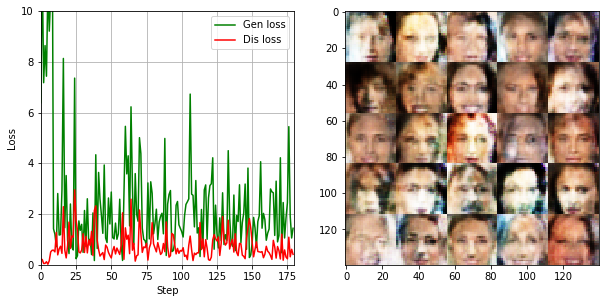

Epc: 1/1    Bat: 1810/3165    Dis Loss: 0.7030    Gen Loss: 1.2555    Time elaps: 00:06:23    Time remain: 00:04:47.
Epc: 1/1    Bat: 1820/3165    Dis Loss: 0.2195    Gen Loss: 2.1595    Time elaps: 00:06:25    Time remain: 00:04:45.
Epc: 1/1    Bat: 1830/3165    Dis Loss: 0.1478    Gen Loss: 2.7277    Time elaps: 00:06:28    Time remain: 00:04:43.
Epc: 1/1    Bat: 1840/3165    Dis Loss: 0.3966    Gen Loss: 1.5786    Time elaps: 00:06:30    Time remain: 00:04:41.
Epc: 1/1    Bat: 1850/3165    Dis Loss: 0.1757    Gen Loss: 3.1956    Time elaps: 00:06:32    Time remain: 00:04:38.
Epc: 1/1    Bat: 1860/3165    Dis Loss: 0.2385    Gen Loss: 3.4356    Time elaps: 00:06:34    Time remain: 00:04:36.
Epc: 1/1    Bat: 1870/3165    Dis Loss: 0.1176    Gen Loss: 3.1776    Time elaps: 00:06:36    Time remain: 00:04:34.
Epc: 1/1    Bat: 1880/3165    Dis Loss: 0.3375    Gen Loss: 3.0847    Time elaps: 00:06:38    Time remain: 00:04:32.
Epc: 1/1    Bat: 1890/3165    Dis Loss: 3.3225    Gen Loss: 0.06

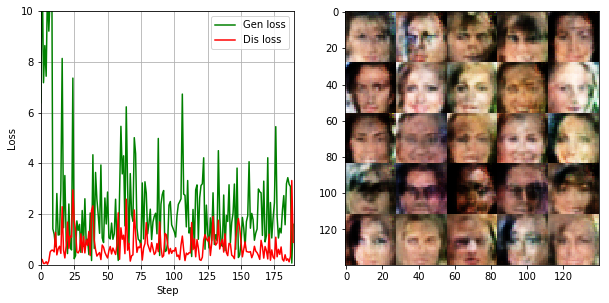

Epc: 1/1    Bat: 1910/3165    Dis Loss: 1.5189    Gen Loss: 0.3721    Time elaps: 00:06:45    Time remain: 00:04:26.
Epc: 1/1    Bat: 1920/3165    Dis Loss: 0.5790    Gen Loss: 1.2833    Time elaps: 00:06:47    Time remain: 00:04:24.
Epc: 1/1    Bat: 1930/3165    Dis Loss: 0.1352    Gen Loss: 4.4515    Time elaps: 00:06:49    Time remain: 00:04:22.
Epc: 1/1    Bat: 1940/3165    Dis Loss: 0.2210    Gen Loss: 2.5305    Time elaps: 00:06:51    Time remain: 00:04:19.
Epc: 1/1    Bat: 1950/3165    Dis Loss: 0.3941    Gen Loss: 2.0719    Time elaps: 00:06:53    Time remain: 00:04:17.
Epc: 1/1    Bat: 1960/3165    Dis Loss: 1.6980    Gen Loss: 0.3071    Time elaps: 00:06:55    Time remain: 00:04:15.
Epc: 1/1    Bat: 1970/3165    Dis Loss: 0.5383    Gen Loss: 1.7719    Time elaps: 00:06:57    Time remain: 00:04:13.
Epc: 1/1    Bat: 1980/3165    Dis Loss: 0.3206    Gen Loss: 3.7974    Time elaps: 00:06:59    Time remain: 00:04:11.
Epc: 1/1    Bat: 1990/3165    Dis Loss: 1.4989    Gen Loss: 2.09

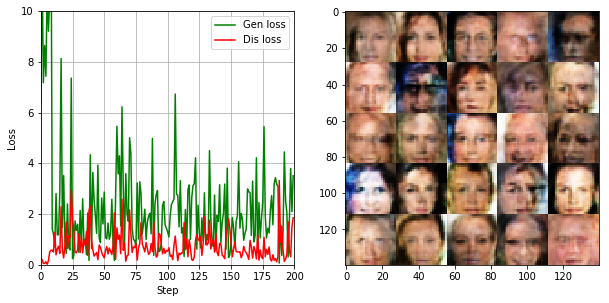

Epc: 1/1    Bat: 2010/3165    Dis Loss: 0.6868    Gen Loss: 1.2673    Time elaps: 00:07:06    Time remain: 00:04:05.
Epc: 1/1    Bat: 2020/3165    Dis Loss: 0.3107    Gen Loss: 2.2857    Time elaps: 00:07:08    Time remain: 00:04:02.
Epc: 1/1    Bat: 2030/3165    Dis Loss: 0.4098    Gen Loss: 1.8981    Time elaps: 00:07:10    Time remain: 00:04:00.
Epc: 1/1    Bat: 2040/3165    Dis Loss: 0.2035    Gen Loss: 2.2959    Time elaps: 00:07:12    Time remain: 00:03:58.
Epc: 1/1    Bat: 2050/3165    Dis Loss: 0.4241    Gen Loss: 1.8124    Time elaps: 00:07:14    Time remain: 00:03:56.
Epc: 1/1    Bat: 2060/3165    Dis Loss: 0.3931    Gen Loss: 2.8278    Time elaps: 00:07:16    Time remain: 00:03:54.
Epc: 1/1    Bat: 2070/3165    Dis Loss: 2.1424    Gen Loss: 3.1962    Time elaps: 00:07:18    Time remain: 00:03:52.
Epc: 1/1    Bat: 2080/3165    Dis Loss: 1.5929    Gen Loss: 0.3660    Time elaps: 00:07:20    Time remain: 00:03:50.
Epc: 1/1    Bat: 2090/3165    Dis Loss: 0.5767    Gen Loss: 1.23

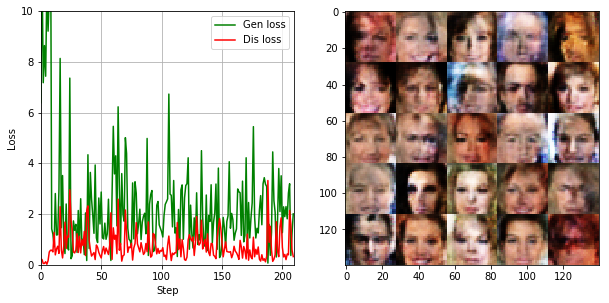

Epc: 1/1    Bat: 2110/3165    Dis Loss: 0.4339    Gen Loss: 1.5584    Time elaps: 00:07:27    Time remain: 00:03:43.
Epc: 1/1    Bat: 2120/3165    Dis Loss: 0.7879    Gen Loss: 0.8358    Time elaps: 00:07:29    Time remain: 00:03:41.
Epc: 1/1    Bat: 2130/3165    Dis Loss: 0.7877    Gen Loss: 0.8632    Time elaps: 00:07:31    Time remain: 00:03:39.
Epc: 1/1    Bat: 2140/3165    Dis Loss: 0.2837    Gen Loss: 1.9283    Time elaps: 00:07:33    Time remain: 00:03:37.
Epc: 1/1    Bat: 2150/3165    Dis Loss: 0.1409    Gen Loss: 2.9635    Time elaps: 00:07:35    Time remain: 00:03:35.
Epc: 1/1    Bat: 2160/3165    Dis Loss: 0.4599    Gen Loss: 1.6125    Time elaps: 00:07:37    Time remain: 00:03:33.
Epc: 1/1    Bat: 2170/3165    Dis Loss: 0.3959    Gen Loss: 1.6999    Time elaps: 00:07:39    Time remain: 00:03:30.
Epc: 1/1    Bat: 2180/3165    Dis Loss: 0.2633    Gen Loss: 2.1467    Time elaps: 00:07:41    Time remain: 00:03:28.
Epc: 1/1    Bat: 2190/3165    Dis Loss: 0.3217    Gen Loss: 2.98

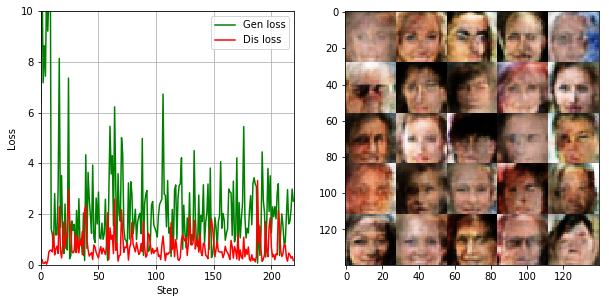

Epc: 1/1    Bat: 2210/3165    Dis Loss: 2.0043    Gen Loss: 0.2260    Time elaps: 00:07:48    Time remain: 00:03:22.
Epc: 1/1    Bat: 2220/3165    Dis Loss: 0.4717    Gen Loss: 1.5941    Time elaps: 00:07:50    Time remain: 00:03:20.
Epc: 1/1    Bat: 2230/3165    Dis Loss: 0.6983    Gen Loss: 3.3684    Time elaps: 00:07:52    Time remain: 00:03:18.
Epc: 1/1    Bat: 2240/3165    Dis Loss: 0.5492    Gen Loss: 1.3001    Time elaps: 00:07:54    Time remain: 00:03:16.
Epc: 1/1    Bat: 2250/3165    Dis Loss: 0.4984    Gen Loss: 2.8396    Time elaps: 00:07:56    Time remain: 00:03:14.
Epc: 1/1    Bat: 2260/3165    Dis Loss: 0.5414    Gen Loss: 2.1224    Time elaps: 00:07:58    Time remain: 00:03:11.
Epc: 1/1    Bat: 2270/3165    Dis Loss: 1.8150    Gen Loss: 0.2696    Time elaps: 00:08:01    Time remain: 00:03:09.
Epc: 1/1    Bat: 2280/3165    Dis Loss: 0.7520    Gen Loss: 1.6982    Time elaps: 00:08:03    Time remain: 00:03:07.
Epc: 1/1    Bat: 2290/3165    Dis Loss: 0.6039    Gen Loss: 1.19

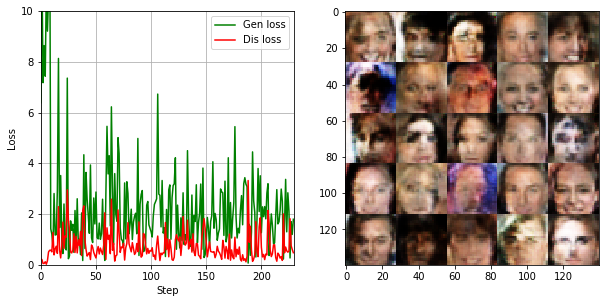

Epc: 1/1    Bat: 2310/3165    Dis Loss: 0.3455    Gen Loss: 2.3247    Time elaps: 00:08:09    Time remain: 00:03:01.
Epc: 1/1    Bat: 2320/3165    Dis Loss: 0.3037    Gen Loss: 2.7000    Time elaps: 00:08:11    Time remain: 00:02:59.
Epc: 1/1    Bat: 2330/3165    Dis Loss: 0.2767    Gen Loss: 1.9417    Time elaps: 00:08:13    Time remain: 00:02:57.
Epc: 1/1    Bat: 2340/3165    Dis Loss: 0.4264    Gen Loss: 2.6073    Time elaps: 00:08:15    Time remain: 00:02:54.
Epc: 1/1    Bat: 2350/3165    Dis Loss: 0.3848    Gen Loss: 1.6247    Time elaps: 00:08:18    Time remain: 00:02:52.
Epc: 1/1    Bat: 2360/3165    Dis Loss: 0.3610    Gen Loss: 2.5551    Time elaps: 00:08:20    Time remain: 00:02:50.
Epc: 1/1    Bat: 2370/3165    Dis Loss: 0.7339    Gen Loss: 0.9474    Time elaps: 00:08:22    Time remain: 00:02:48.
Epc: 1/1    Bat: 2380/3165    Dis Loss: 0.7329    Gen Loss: 1.1690    Time elaps: 00:08:24    Time remain: 00:02:46.
Epc: 1/1    Bat: 2390/3165    Dis Loss: 0.3728    Gen Loss: 4.08

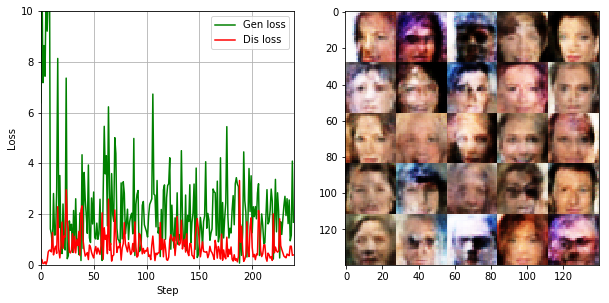

Epc: 1/1    Bat: 2410/3165    Dis Loss: 0.3743    Gen Loss: 2.4414    Time elaps: 00:08:30    Time remain: 00:02:40.
Epc: 1/1    Bat: 2420/3165    Dis Loss: 0.3634    Gen Loss: 3.5800    Time elaps: 00:08:32    Time remain: 00:02:38.
Epc: 1/1    Bat: 2430/3165    Dis Loss: 0.3194    Gen Loss: 3.4950    Time elaps: 00:08:34    Time remain: 00:02:35.
Epc: 1/1    Bat: 2440/3165    Dis Loss: 1.5146    Gen Loss: 0.9442    Time elaps: 00:08:37    Time remain: 00:02:33.
Epc: 1/1    Bat: 2450/3165    Dis Loss: 0.4511    Gen Loss: 1.5520    Time elaps: 00:08:39    Time remain: 00:02:31.
Epc: 1/1    Bat: 2460/3165    Dis Loss: 0.3038    Gen Loss: 2.5923    Time elaps: 00:08:41    Time remain: 00:02:29.
Epc: 1/1    Bat: 2470/3165    Dis Loss: 0.9809    Gen Loss: 0.6930    Time elaps: 00:08:43    Time remain: 00:02:27.
Epc: 1/1    Bat: 2480/3165    Dis Loss: 0.3868    Gen Loss: 1.5585    Time elaps: 00:08:45    Time remain: 00:02:25.
Epc: 1/1    Bat: 2490/3165    Dis Loss: 0.1796    Gen Loss: 3.05

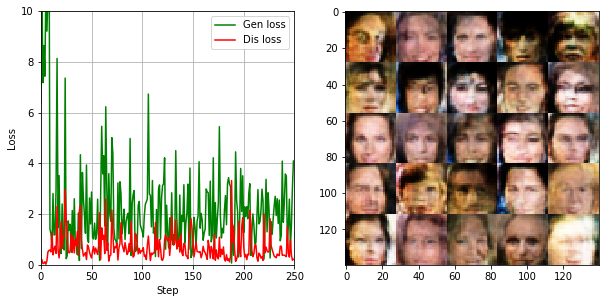

Epc: 1/1    Bat: 2510/3165    Dis Loss: 0.6341    Gen Loss: 3.9597    Time elaps: 00:08:52    Time remain: 00:02:18.
Epc: 1/1    Bat: 2520/3165    Dis Loss: 0.3554    Gen Loss: 1.6652    Time elaps: 00:08:54    Time remain: 00:02:16.
Epc: 1/1    Bat: 2530/3165    Dis Loss: 2.1901    Gen Loss: 3.6170    Time elaps: 00:08:56    Time remain: 00:02:14.
Epc: 1/1    Bat: 2540/3165    Dis Loss: 1.2342    Gen Loss: 0.5008    Time elaps: 00:08:58    Time remain: 00:02:12.
Epc: 1/1    Bat: 2550/3165    Dis Loss: 0.5335    Gen Loss: 2.1265    Time elaps: 00:09:00    Time remain: 00:02:10.
Epc: 1/1    Bat: 2560/3165    Dis Loss: 0.4770    Gen Loss: 1.4538    Time elaps: 00:09:02    Time remain: 00:02:08.
Epc: 1/1    Bat: 2570/3165    Dis Loss: 0.1466    Gen Loss: 3.3049    Time elaps: 00:09:04    Time remain: 00:02:06.
Epc: 1/1    Bat: 2580/3165    Dis Loss: 0.1655    Gen Loss: 2.7058    Time elaps: 00:09:06    Time remain: 00:02:04.
Epc: 1/1    Bat: 2590/3165    Dis Loss: 0.2161    Gen Loss: 2.45

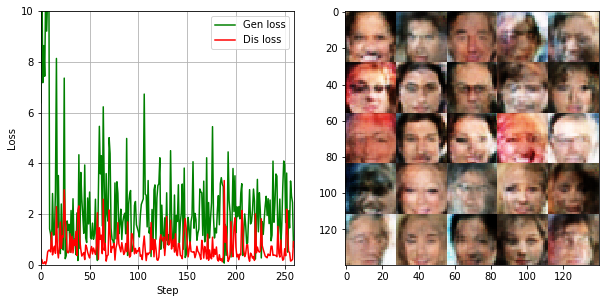

Epc: 1/1    Bat: 2610/3165    Dis Loss: 0.1280    Gen Loss: 2.8740    Time elaps: 00:09:13    Time remain: 00:01:57.
Epc: 1/1    Bat: 2620/3165    Dis Loss: 0.1495    Gen Loss: 2.7590    Time elaps: 00:09:15    Time remain: 00:01:55.
Epc: 1/1    Bat: 2630/3165    Dis Loss: 0.4538    Gen Loss: 1.4099    Time elaps: 00:09:17    Time remain: 00:01:53.
Epc: 1/1    Bat: 2640/3165    Dis Loss: 0.1934    Gen Loss: 2.9924    Time elaps: 00:09:19    Time remain: 00:01:51.
Epc: 1/1    Bat: 2650/3165    Dis Loss: 0.3648    Gen Loss: 1.7417    Time elaps: 00:09:21    Time remain: 00:01:49.
Epc: 1/1    Bat: 2660/3165    Dis Loss: 1.0332    Gen Loss: 0.6702    Time elaps: 00:09:23    Time remain: 00:01:47.
Epc: 1/1    Bat: 2670/3165    Dis Loss: 0.3386    Gen Loss: 2.8386    Time elaps: 00:09:25    Time remain: 00:01:44.
Epc: 1/1    Bat: 2680/3165    Dis Loss: 1.2096    Gen Loss: 3.6538    Time elaps: 00:09:27    Time remain: 00:01:42.
Epc: 1/1    Bat: 2690/3165    Dis Loss: 0.3754    Gen Loss: 1.76

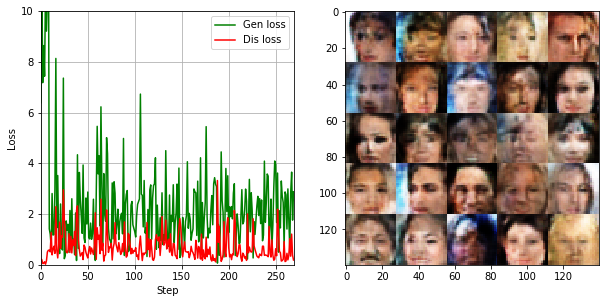

Epc: 1/1    Bat: 2710/3165    Dis Loss: 0.4143    Gen Loss: 1.7338    Time elaps: 00:09:34    Time remain: 00:01:36.
Epc: 1/1    Bat: 2720/3165    Dis Loss: 0.3383    Gen Loss: 1.9373    Time elaps: 00:09:36    Time remain: 00:01:34.
Epc: 1/1    Bat: 2730/3165    Dis Loss: 0.4900    Gen Loss: 2.3420    Time elaps: 00:09:38    Time remain: 00:01:32.
Epc: 1/1    Bat: 2740/3165    Dis Loss: 1.6923    Gen Loss: 3.6537    Time elaps: 00:09:40    Time remain: 00:01:30.
Epc: 1/1    Bat: 2750/3165    Dis Loss: 0.5998    Gen Loss: 1.8208    Time elaps: 00:09:42    Time remain: 00:01:28.
Epc: 1/1    Bat: 2760/3165    Dis Loss: 0.1529    Gen Loss: 2.7646    Time elaps: 00:09:44    Time remain: 00:01:25.
Epc: 1/1    Bat: 2770/3165    Dis Loss: 0.9359    Gen Loss: 0.7651    Time elaps: 00:09:46    Time remain: 00:01:23.
Epc: 1/1    Bat: 2780/3165    Dis Loss: 0.5715    Gen Loss: 1.2155    Time elaps: 00:09:49    Time remain: 00:01:21.
Epc: 1/1    Bat: 2790/3165    Dis Loss: 0.1750    Gen Loss: 6.93

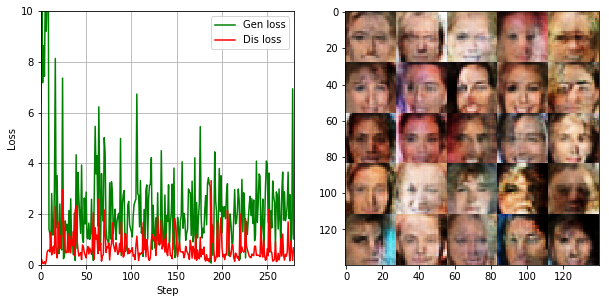

Epc: 1/1    Bat: 2810/3165    Dis Loss: 0.1179    Gen Loss: 3.3048    Time elaps: 00:09:55    Time remain: 00:01:15.
Epc: 1/1    Bat: 2820/3165    Dis Loss: 0.1835    Gen Loss: 2.5711    Time elaps: 00:09:57    Time remain: 00:01:13.
Epc: 1/1    Bat: 2830/3165    Dis Loss: 0.7735    Gen Loss: 3.6795    Time elaps: 00:09:59    Time remain: 00:01:11.
Epc: 1/1    Bat: 2840/3165    Dis Loss: 1.2454    Gen Loss: 4.5144    Time elaps: 00:10:01    Time remain: 00:01:09.
Epc: 1/1    Bat: 2850/3165    Dis Loss: 1.1024    Gen Loss: 2.3468    Time elaps: 00:10:04    Time remain: 00:01:06.
Epc: 1/1    Bat: 2860/3165    Dis Loss: 0.5974    Gen Loss: 4.2350    Time elaps: 00:10:06    Time remain: 00:01:04.
Epc: 1/1    Bat: 2870/3165    Dis Loss: 0.4810    Gen Loss: 2.4696    Time elaps: 00:10:08    Time remain: 00:01:02.
Epc: 1/1    Bat: 2880/3165    Dis Loss: 0.1594    Gen Loss: 2.5006    Time elaps: 00:10:10    Time remain: 00:01:00.
Epc: 1/1    Bat: 2890/3165    Dis Loss: 1.1708    Gen Loss: 1.49

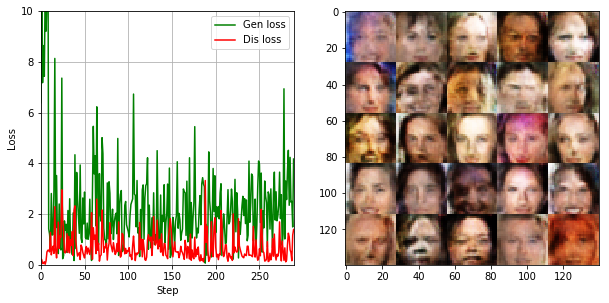

Epc: 1/1    Bat: 2910/3165    Dis Loss: 0.1880    Gen Loss: 2.4100    Time elaps: 00:10:16    Time remain: 00:00:54.
Epc: 1/1    Bat: 2920/3165    Dis Loss: 0.1493    Gen Loss: 3.2517    Time elaps: 00:10:18    Time remain: 00:00:52.
Epc: 1/1    Bat: 2930/3165    Dis Loss: 0.8768    Gen Loss: 0.7294    Time elaps: 00:10:21    Time remain: 00:00:49.
Epc: 1/1    Bat: 2940/3165    Dis Loss: 1.4243    Gen Loss: 0.4101    Time elaps: 00:10:23    Time remain: 00:00:47.
Epc: 1/1    Bat: 2950/3165    Dis Loss: 1.2076    Gen Loss: 3.8374    Time elaps: 00:10:25    Time remain: 00:00:45.
Epc: 1/1    Bat: 2960/3165    Dis Loss: 0.3298    Gen Loss: 3.6296    Time elaps: 00:10:27    Time remain: 00:00:43.
Epc: 1/1    Bat: 2970/3165    Dis Loss: 2.0665    Gen Loss: 4.3473    Time elaps: 00:10:29    Time remain: 00:00:41.
Epc: 1/1    Bat: 2980/3165    Dis Loss: 0.5673    Gen Loss: 1.3007    Time elaps: 00:10:31    Time remain: 00:00:39.
Epc: 1/1    Bat: 2990/3165    Dis Loss: 0.6197    Gen Loss: 1.13

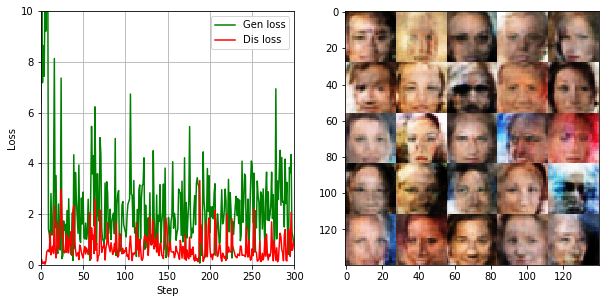

Epc: 1/1    Bat: 3010/3165    Dis Loss: 0.2329    Gen Loss: 2.2616    Time elaps: 00:10:38    Time remain: 00:00:32.
Epc: 1/1    Bat: 3020/3165    Dis Loss: 0.7370    Gen Loss: 1.1277    Time elaps: 00:10:40    Time remain: 00:00:30.
Epc: 1/1    Bat: 3030/3165    Dis Loss: 0.2809    Gen Loss: 2.3831    Time elaps: 00:10:42    Time remain: 00:00:28.
Epc: 1/1    Bat: 3040/3165    Dis Loss: 0.7251    Gen Loss: 0.9518    Time elaps: 00:10:44    Time remain: 00:00:26.
Epc: 1/1    Bat: 3050/3165    Dis Loss: 0.7295    Gen Loss: 0.9219    Time elaps: 00:10:46    Time remain: 00:00:24.
Epc: 1/1    Bat: 3060/3165    Dis Loss: 0.3587    Gen Loss: 1.5669    Time elaps: 00:10:48    Time remain: 00:00:22.
Epc: 1/1    Bat: 3070/3165    Dis Loss: 0.1988    Gen Loss: 2.2934    Time elaps: 00:10:50    Time remain: 00:00:20.
Epc: 1/1    Bat: 3080/3165    Dis Loss: 0.4388    Gen Loss: 1.9928    Time elaps: 00:10:52    Time remain: 00:00:18.
Epc: 1/1    Bat: 3090/3165    Dis Loss: 1.5978    Gen Loss: 4.31

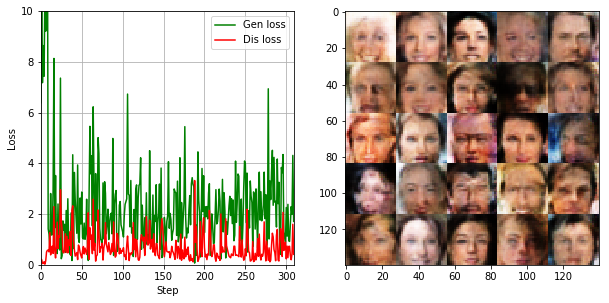

Epc: 1/1    Bat: 3110/3165    Dis Loss: 1.2605    Gen Loss: 0.4916    Time elaps: 00:10:59    Time remain: 00:00:11.
Epc: 1/1    Bat: 3120/3165    Dis Loss: 0.3549    Gen Loss: 1.6858    Time elaps: 00:11:01    Time remain: 00:00:09.
Epc: 1/1    Bat: 3130/3165    Dis Loss: 1.3519    Gen Loss: 0.5053    Time elaps: 00:11:03    Time remain: 00:00:07.
Epc: 1/1    Bat: 3140/3165    Dis Loss: 0.5063    Gen Loss: 3.9294    Time elaps: 00:11:05    Time remain: 00:00:05.
Epc: 1/1    Bat: 3150/3165    Dis Loss: 0.2708    Gen Loss: 2.0920    Time elaps: 00:11:07    Time remain: 00:00:03.
Epc: 1/1    Bat: 3160/3165    Dis Loss: 0.1496    Gen Loss: 2.9494    Time elaps: 00:11:09    Time remain: 00:00:01.


In [202]:
batch_size =64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.